# Prepare

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy

import experiments as meas
from slab import AttrDict
from meas_utils import MultimodeStation, CharacterizationRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

Importing all classes from  D:\python\multimode_expts\experiments\dual_rail
Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']


C:\Users\26049\AppData\Local\Temp\ipykernel_9396\3925777550.py:11: DeprecationWarning: meas_utils is deprecated. Import from 'experiments' instead:
  from experiments import MultimodeStation, SweepRunner, CharacterizationRunner
  from meas_utils import MultimodeStation, CharacterizationRunner


Server status: healthy
Pending jobs: 0


In [2]:
# Who is running these experiments??
user = 'connie'

print(f"Welcome {user}!")

Welcome connie!


In [3]:
# Initialize station to retrieve soc and configs
station = MultimodeStation(
    user = user,
    experiment_name = "260130_qsim_wigner",

    # storage_man_file = "CFG-M1-20260122-00013",
    # storage_man_file='CFG-M1-20260127-00034',
    # hardware_config="versions/hardware_config/CFG-HW-20260121-00006.yml",
    # floquet_file="versions/floquet_storage_swap/CFG-FL-20260115-00001.csv",
    # storage_man_file="versions/man1_storage_swap/CFG-M1-20260121-00005.csv",
    # multiphoton_config="versions/multiphoton_config/CFG-MP-20260115-00001.yml",
    
    # experiment_name = "251111_qec",
)

[STATION] Using main hardware_config version: CFG-HW-20260203-00006
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260203-00003
[STATION] Using main floquet_storage_swap version: CFG-FL-20260203-00010
Data, plots, logs will be stored in: D:\experiments\260130_qsim_wigner
Hardware configs will be read from D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260203-00006.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-b

## Datset for Sidebands

In [4]:
station.ds_floquet.df

stor_name  pi_frac   freq (MHz)  gain (DAC units)  len (mus)  \
0     M1-S1        1   352.801932              9142   0.714658   
1     M1-S2       30   524.901866              7427   0.045011   
2     M1-S3       40   700.819696              4689   0.044762   
3     M1-S4       30   880.783627             10486   0.045009   
4     M1-S5       30  1057.117751              9972   0.064685   
5     M1-S6       40  1248.656279             12734   0.048007   
6     M1-S7       30  1426.988664              8309   0.135532   

   ramp_sigma (mus)  phase_from_M1-S1 (deg)  phase_from_M1-S2 (deg)  \
0          0.005008                0.000000                3.124849   
1          0.005008               -3.492669                0.000000   
2          0.005008                0.808874                4.753306   
3          0.005008                0.000000                0.000000   
4          0.005008                0.000000                0.000000   
5          0.005008                0.000000                3.591544   
6          0.005008                0.000000                4.529378   

   phase_from_M1-S3 (deg)  phase_from_M1-S4 (deg)  phase_from_M1-S5 (deg)  \
0               -0.272690                     0.0                     0.0   
1               -3.957270                     0.0                     0.0   
2                0.000000                     0.0                     0.0   
3                0.000000                     0.0                     0.0   
4                0.000000                     0.0                     0.0   
5                1.160044                     0.0                     0.0   
6                1.914683                     0.0                     0.0   

   phase_from_M1-S6 (deg)  phase_from_M1-S7 (deg)                 last_update  
0                0.000000                0.000000  2026-02-03 10:54:45.499665  
1               -2.695980               -6.049181  2026-02-03 10:54:45.507667  
2               -0.697611               -2.604314  2026-02-03 10:54:45.512665  
3                0.000000                0.000000  2026-02-03 10:54:45.516666  
4                0.000000                0.000000  2026-02-03 10:54:45.520665  
5                0.000000               -0.994739  2026-02-03 10:54:45.524665  
6                1.045383                0.000000  2026-02-03 10:54:45.528665

In [9]:
station.ds_storage.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.809946              NaN   1.747925    0.987691   
1      M1-S2   524.901866              NaN   1.350331    0.675166   
2      M1-S3   700.819696              NaN   1.790496    0.895248   
3      M1-S4   880.783627              NaN   1.350274    0.675137   
4      M1-S5  1057.117751              NaN   1.940550    0.970275   
5      M1-S6  1248.656279              NaN   1.920297    0.960149   
6      M1-S7  1426.988664              NaN   4.065962    2.032981   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  1998.642844              NaN   0.577254    0.283179   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2373.600000             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   919.000000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  \
0               3813  2026-01-30 13:17:59.925689   
1               7427  2026-01-27 16:32:11.389298   
2               4689  2026-01-27 17:39:17.881900   
3              10486  2026-01-27 15:38:47.266784   
4               9972  2026-01-27 17:28:20.358092   
5              12734  2026-01-27 14:31:33.984866   
6               8309  2026-01-27 14:33:07.115055   
7                 -1                     51:31.3   
8                 -1                     51:31.3   
9                 -1                     51:31.3   
10                -1                     51:31.3   
11                -1                     51:31.3   
12              8000  2026-01-19 11:06:42.086262   
13             15000  2025-04-30 11:22:11.432806   
14              1000                     28:20.8   
15              5000                     33:56.1   
16              5000                     22:30.3   
17              9000                     25:33.1   
18             13500                     00:05.4   
19              9000                     30:59.0   
20             12000                     56:07.5   
21              2000  2024-10-06 01:47:25.946153   
22              4000  2025-10-28 16:37:57.400701   
23              8000  2025-01-23 17:22:53.776061   
24              1000  2025-12-08 16:40:53.078714   
25             15000  2025-01-20 09:52:35.311227   

                                     bs_rate_coeffs_g  \
0   [2.71800440497595e-10, 3.5345716702085755e-05,...   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11                                                

In [10]:
station.ds_floquet.get_columns()

['stor_name',
 'pi_frac',
 'freq (MHz)',
 'gain (DAC units)',
 'len (mus)',
 'ramp_sigma (mus)',
 'phase_from_M1-S1 (deg)',
 'phase_from_M1-S2 (deg)',
 'phase_from_M1-S3 (deg)',
 'phase_from_M1-S4 (deg)',
 'phase_from_M1-S5 (deg)',
 'phase_from_M1-S6 (deg)',
 'phase_from_M1-S7 (deg)',
 'last_update']

In [ ]:
# # Initializing this run dataset to some guess values based on standard storage pulses

# for s in range(1, 8, 1):
#     stor_name = f'M1-S{s}'
#     pi_frac = 12
#     freq = station.ds_storage.get_freq(f'M1-S{s}')
#     gain = station.ds_storage.get_gain(f'M1-S{s}') / 3
#     length = station.ds_storage.get_h_pi(f'M1-S{s}') / 2
#     ramp_sigma = station.soc.cycles2us(2, gen_ch=1)
#     station.ds_floquet.update_freq(stor_name, freq)
#     station.ds_floquet.update_pi_frac(stor_name, pi_frac)
#     station.ds_floquet.update_gain(stor_name, gain)
#     station.ds_floquet.update_len(stor_name, length)
#     station.ds_floquet.update_ramp_sigma(stor_name, ramp_sigma)

# # Save dataset
# station.snapshot_floquet_storage_swap(update_main=True)

[CONFIG] Created new floquet_storage_swap version CFG-FL-20260130-00001
[CONFIG] Updated main floquet_storage_swap to CFG-FL-20260130-00001


'CFG-FL-20260130-00001'

In [16]:
# file_path_old = os.path.join(expts_path, 'floquet_storage_swap_dataset_backup.csv')
# # print(os.makedirs(file_path, exist_ok=True))
# ds_backup = floquet_storage_swap_dataset(file_path_old)
# ds_backup.df

In [17]:
# # Initializing this run dataset to some values from another csv with different columns

# for s in range(1, 8, 1):
#     stor_name = f'M1-S{s}'
#     for col in ds_thisrun.df.columns:
#         if col in ds_backup.df.columns:
#             ds_thisrun.df[col] = ds_backup.df[col].copy()
#     # ds_thisrun.update_all(stor_name, pi_frac, freq, gain, length, ramp_sigma, stark_shift) 
# ds_thisrun.df
# # Save dataset to file
# ds.df = ds_thisrun.df.copy()
# ds.save_to_file(ds.filename)

In [4]:
from experiments.MM_dual_rail_base import MM_dual_rail_base
def get_floquet_parameters(station, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        station: MultimodeStation object for managing frequency data.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = station.ds_floquet.get_freq(stor_name)
    gain = station.ds_floquet.get_gain(stor_name)
    length = station.ds_floquet.get_len(stor_name)
    pi_frac = station.ds_floquet.get_pi_frac(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    mm_base_dummy = MM_dual_rail_base(station.hardware_cfg, station.soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, length, pi_frac, ch, prepulse, postpulse


# Floquet pulse calibrations

In [15]:
# Override/initalize using the storage dataset
station.ds_floquet.import_from_swap_dataset(station.ds_storage, gain_div=1, 
                                    pi_div=[50,30,40,30,30,40,30])
station.snapshot_floquet_storage_swap(update_main=True)

[CONFIG] Created new floquet_storage_swap version CFG-FL-20260203-00009
[CONFIG] Updated main floquet_storage_swap to CFG-FL-20260203-00009


'CFG-FL-20260203-00009'

## Freq chevron

In [20]:
station.ds_floquet.df

stor_name  pi_frac   freq (MHz)  gain (DAC units)  len (mus)  \
0     M1-S1       50   352.801932              9142   0.014293   
1     M1-S2       30   524.901866              7427   0.045011   
2     M1-S3       40   700.819696              4689   0.044762   
3     M1-S4       30   880.783627             10486   0.045009   
4     M1-S5       30  1057.117751              9972   0.064685   
5     M1-S6       40  1248.656279             12734   0.048007   
6     M1-S7       30  1426.988664              8309   0.135532   

   ramp_sigma (mus)  phase_from_M1-S1 (deg)  phase_from_M1-S2 (deg)  \
0          0.005008                0.000000                3.124849   
1          0.005008               -3.492669                0.000000   
2          0.005008                0.808874                4.753306   
3          0.005008                0.000000                0.000000   
4          0.005008                0.000000                0.000000   
5          0.005008                0.000000                3.591544   
6          0.005008                0.000000                4.529378   

   phase_from_M1-S3 (deg)  phase_from_M1-S4 (deg)  phase_from_M1-S5 (deg)  \
0               -0.272690                     0.0                     0.0   
1               -3.957270                     0.0                     0.0   
2                0.000000                     0.0                     0.0   
3                0.000000                     0.0                     0.0   
4                0.000000                     0.0                     0.0   
5                1.160044                     0.0                     0.0   
6                1.914683                     0.0                     0.0   

   phase_from_M1-S6 (deg)  phase_from_M1-S7 (deg)                 last_update  
0                0.000000                0.000000  2026-02-03 12:07:36.875373  
1               -2.695980               -6.049181  2026-02-03 12:07:36.879375  
2               -0.697611               -2.604314  2026-02-03 12:07:36.882375  
3                0.000000                0.000000  2026-02-03 12:07:36.886391  
4                0.000000                0.000000  2026-02-03 12:07:36.890375  
5                0.000000               -0.994739  2026-02-03 12:07:36.893377  
6                1.045383                0.000000  2026-02-03 12:07:36.897344

In [17]:
floquet_freq_chev_defaults = AttrDict(dict(
    expts = 1,
    reps = 100,
    rounds = 1,
    qubits = [0],
    ro_stor = 0, # storage mode number that gets read out in the end
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    # if 0, this means to read out man instead
    detunes=np.linspace(-0.3, 0.3, 11).tolist(),
    swept_params = ['detune', 'length'],
    normalize = False,
    active_reset = False,
    man_reset = False, 
    storage_reset = False, 
    prepulse=True,
    postpulse=True,
    init_fock=True,
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def floquet_freq_chev_preproc(station, default_expt_cfg, **kwargs):
    assert 'init_stor' in kwargs
    expt_cfg = deepcopy(default_expt_cfg)
    ds_floquet = station.ds_floquet
    init_stor = kwargs.pop('init_stor') # storage mode number to initialize to n=1 Fock state
    lengths = np.linspace(0.01, 3.0 * ds_floquet.get_len(f'M1-S{init_stor}'), 10).tolist()

    expt_cfg.init_stor = init_stor
    expt_cfg.lengths = lengths
    expt_cfg.update(kwargs)
    print(expt_cfg)
    return expt_cfg

Running Floquet Frequency vs Length Chevron for Storage Mode 3
{'expts': 1, 'reps': 50, 'rounds': 1, 'qubits': [0], 'ro_stor': 0, 'f0g1_cavity': 1, 'detunes': [-0.3, -0.24, -0.18, -0.12, -0.06, 0.0, 0.06, 0.12, 0.18, 0.24000000000000005, 0.3], 'swept_params': ['detune', 'length'], 'normalize': False, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'prepulse': True, 'postpulse': True, 'init_fock': True, 'init_stor': 3, 'lengths': [0.01, 0.023809691726067644, 0.037619383452135294, 0.051429075178202936, 0.06523876690427058, 0.07904845863033823, 0.09285815035640586, 0.10666784208247351, 0.12047753380854116, 0.1342872255346088], 'relax_delay': 8000}
Job submitted: JOB-20260203-00057 (queue position: 1)

[0.1s] Job JOB-20260203-00057: pending

[2.1s] Job JOB-20260203-00057: running
[WORKER] Loading FloquetChevronExperiment from experiments.qsim.floquet_chevron
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00057_FloquetChevronExperiment.h5
[WORKER

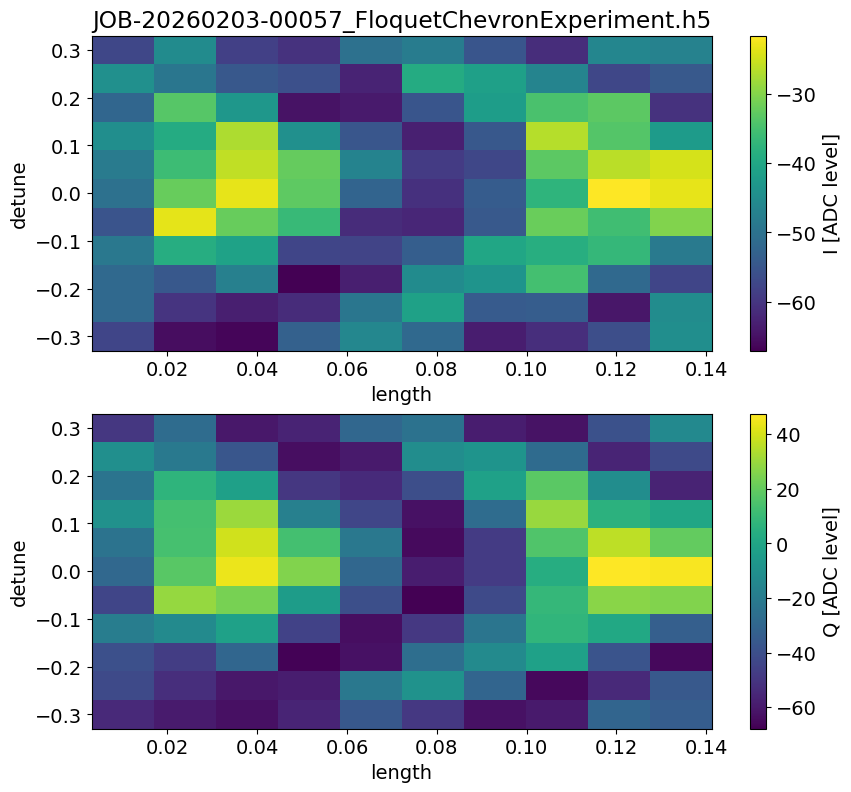

In [19]:
stor_modes_to_run = [3] #list(range(1,8))
freq_len_expt = [None] * len(stor_modes_to_run)

floquet_freq_chev_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.FloquetChevronExperiment,
    ExptProgram=meas.FloquetChevronProgram,
    default_expt_cfg=floquet_freq_chev_defaults,
    preprocessor=floquet_freq_chev_preproc,
    postprocessor=None,
    job_client=client,
)

for i, init_stor in enumerate(stor_modes_to_run):
    # ds_floquet.update_gain(f'M1-S{init_stor}', ds_floquet.get_gain(f'M1-S{init_stor}') * 0.75)
    # print(f'Updating gain for M1-S{init_stor} to {ds_floquet.get_gain(f"M1-S{init_stor}")}')

    print(f'Running Floquet Frequency vs Length Chevron for Storage Mode {init_stor}')
    freq_len_expt[i] = floquet_freq_chev_runner.execute(
        init_stor=init_stor,
        # detunes=np.linspace(-1.0, 1.0, 21).tolist(),
        relax_delay=8000,
        reps=50,
    )
    freq_len_expt[i].display()

In [ ]:
qbe = freq_len_expt[0]
# qbe.analyze()

stor_name = f'M1-S{qbe.cfg.expt.init_stor}'
print(stor_name, station.ds_floquet.get_len(stor_name))
# ds_thisrun.update_len(stor_name, 0.300)
station.ds_floquet.update_freq(stor_name, station.ds_floquet.get_freq(stor_name) + 0.05)

M1-S1 0.03872279844700081
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [ ]:
# ds_thisrun.update_freq('M1-S1', ds_thisrun.get_freq('M1-S2') - 0.03)
station.ds_floquet.update_freq('M1-S2', station.ds_floquet.get_freq('M1-S2') - 0.02)
# ds_thisrun.update_freq('M1-S3', ds_thisrun.get_freq('M1-S7') - 0.015)

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [ ]:
# TODO: make some proper fitting and make this an update based on the fit
def floquet_freq_chev_postproc(station, expt):
    station.ds_floquet.update_freq()

## Error amplification on floquet pulses

In [37]:
error_amp_floquet_defaults = AttrDict(dict(
    reps=100,
    rounds=1,
    qubits=[0],
    active_reset=False,
    man_mode_no=1,
    stor_is_dump=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    expts=25,
    qubit_start_storage='g',
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

error_amp_gain_floquet_coarse_defaults = AttrDict(dict(
    n_pulses=10,
    span=5000,
    expts=40,
))

error_amp_freq_floquet_coarse_defaults = AttrDict(dict(
    n_pulses=7,
    span=0.15,
    expts=50,
))


def floquet_freq_chev_preproc(station, default_expt_cfg, **kwargs):
    assert 'stor_mode_no' in kwargs
    assert 'parameter_to_test' in kwargs 

    # construct the defaults
    expt_cfg = deepcopy(default_expt_cfg)
    if kwargs['parameter_to_test'] == 'gain':
        expt_cfg.update(error_amp_gain_floquet_coarse_defaults)
    elif kwargs['parameter_to_test'] == 'frequency':
        expt_cfg.update(error_amp_freq_floquet_coarse_defaults)

    # override with the passed kwargs
    expt_cfg.update(kwargs)

    freq, gain, length, pi_frac, ch, prepulse, postpulse = get_floquet_parameters(station, expt_cfg.man_mode_no, expt_cfg.stor_mode_no)
    pulse_type = ['floquet', f'M{expt_cfg.man_mode_no}-{"D" if expt_cfg.stor_is_dump else "S"}{expt_cfg.stor_mode_no}', f'pi/{pi_frac}', 0]

    if expt_cfg.parameter_to_test == 'frequency':
        start = freq - expt_cfg.span / 2
        step = expt_cfg.span / (expt_cfg.expts - 1)
    elif expt_cfg.parameter_to_test == 'gain':
        start = int(gain - expt_cfg.span / 2)
        step = int(expt_cfg.span / (expt_cfg.expts - 1))
    else:
        raise ValueError("parameter_to_test must be either 'frequency' or 'gain'.")
    expt_cfg.start = start
    expt_cfg.step = step
    expt_cfg.pulse_type = pulse_type 
    return expt_cfg

def floquet_freq_chev_postproc(station, expt):
    expt.analyze(data=expt.data, state_fin='e')

    opt_val = expt.data['fit_avgi'][2]
    stor_name = 'M1-S' + str(expt.cfg.expt.stor_mode_no)
    if expt.cfg.expt.parameter_to_test == 'gain':
        station.ds_floquet.update_gain(stor_name, opt_val)
        print(f'Updated gain for {stor_name} to {opt_val}')
    elif expt.cfg.expt.parameter_to_test == 'frequency':
        station.ds_floquet.update_freq(stor_name, opt_val)
        print(f'Updated frequency for {stor_name} to {opt_val}')
    station.snapshot_floquet_storage_swap(update_main=False)


error_amp_floquet_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
    default_expt_cfg=error_amp_floquet_defaults,
    preprocessor=floquet_freq_chev_preproc,
    postprocessor=floquet_freq_chev_postproc,
    job_client=client,
)

In [30]:
stor_modes_to_run = [1] #list(range(1,8))
error_amp_gain1 = [None] * len(stor_modes_to_run)
error_amp_freq1 = [None] * len(stor_modes_to_run)
error_amp_gain2 = [None] * len(stor_modes_to_run)
error_amp_freq2 = [None] * len(stor_modes_to_run)

### Coarse

Running M1-S1
['multiphoton', 'g0-e0', 'pi', 0]
['multiphoton', 'e0-f0', 'pi', 0]
['multiphoton', 'f0-g1', 'pi', 0]
['multiphoton', 'f0-g1', 'pi', 0]
['multiphoton', 'e0-f0', 'pi', 0]
Job submitted: JOB-20260203-00120 (queue position: 1)

[0.1s] Job JOB-20260203-00120: pending

[57.1s] Job JOB-20260203-00120: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00120_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 100, 'rounds': 1, 'qubits': [0], 'active_reset': False, 'man_mode_no': 1, 'stor_is_dump': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'expts': 40, 'qubit_start_storage': 'g', 'n_pulses': 10, 'span': 5000, 'stor_mode_no': 1, 'parameter_to_test': 'gain', 'go_kwargs': {'analyze': False, 'progress': True, 'display': False}, 'start': 4482, 'step': 128, 'pulse_type': ['floquet', 'M1-S1',

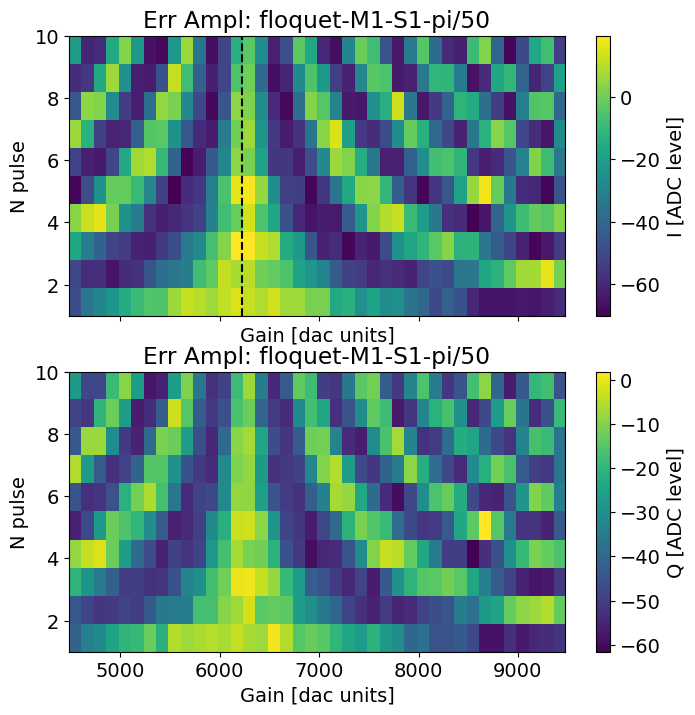

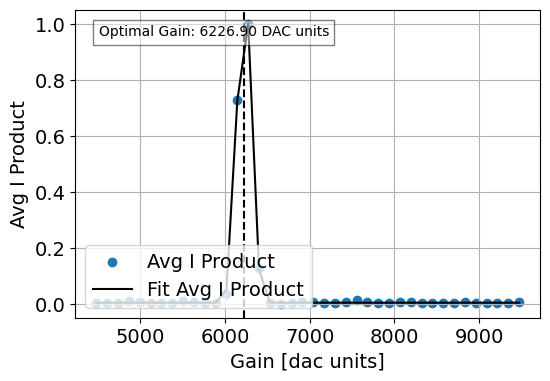

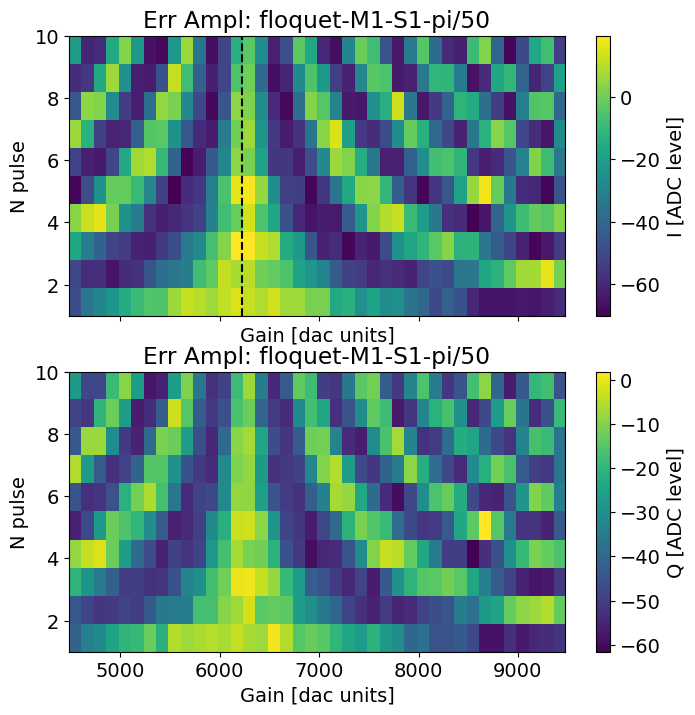

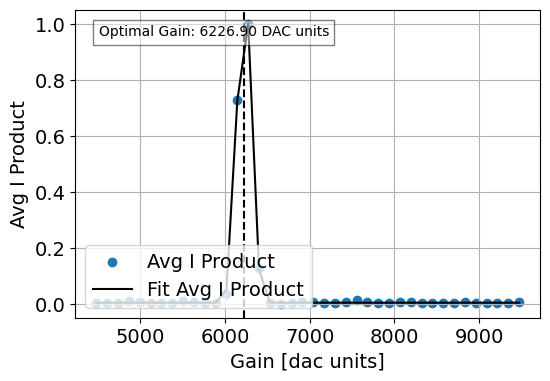

['multiphoton', 'g0-e0', 'pi', 0]
['multiphoton', 'e0-f0', 'pi', 0]
['multiphoton', 'f0-g1', 'pi', 0]
['multiphoton', 'f0-g1', 'pi', 0]
['multiphoton', 'e0-f0', 'pi', 0]
Job submitted: JOB-20260203-00122 (queue position: 1)

[0.1s] Job JOB-20260203-00122: pending

[4.2s] Job JOB-20260203-00122: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00122_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 100, 'rounds': 1, 'qubits': [0], 'active_reset': False, 'man_mode_no': 1, 'stor_is_dump': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'expts': 50, 'qubit_start_storage': 'g', 'n_pulses': 7, 'span': 0.15, 'stor_mode_no': 1, 'parameter_to_test': 'frequency', 'go_kwargs': {'analyze': False, 'progress': True, 'display': False}, 'start': 352.72693159069166, 'step': 0.003061224489795918, 'pulse_type': 

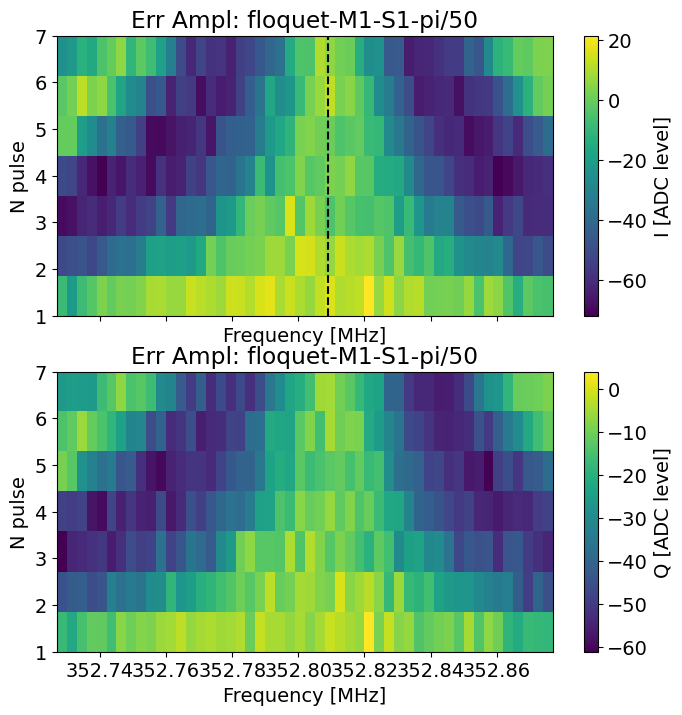

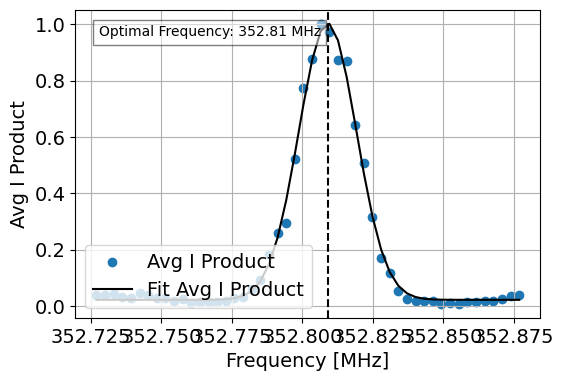

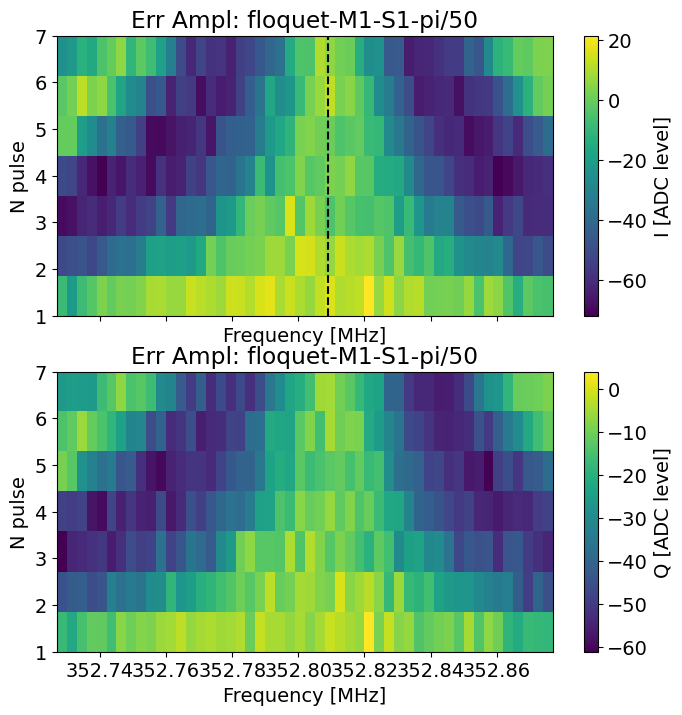

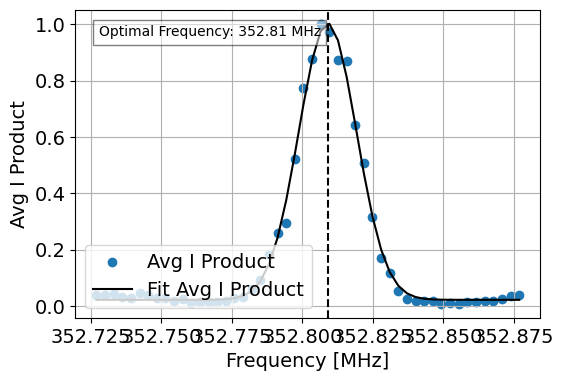

In [34]:
for i, stor_i in enumerate(stor_modes_to_run):
    stor_name = 'M1-S' + str(stor_i)
    print("Running", stor_name)
    error_amp_gain1[i] = error_amp_floquet_runner.execute(
        stor_mode_no=stor_i,
        parameter_to_test='gain',
        go_kwargs=dict(analyze=False, progress=True, display=False),
    )
    error_amp_gain1[i].display()

    error_amp_freq1[i] = error_amp_floquet_runner.execute(
        stor_mode_no=stor_i,
        parameter_to_test='frequency',
        go_kwargs=dict(analyze=False, progress=True, display=False),
    )
    error_amp_freq1[i].display()

In [38]:
station.snapshot_floquet_storage_swap(update_main=True)

[CONFIG] Reusing existing floquet_storage_swap version CFG-FL-20260203-00010
[CONFIG] Updated main floquet_storage_swap to CFG-FL-20260203-00010


'CFG-FL-20260203-00010'

In [36]:
# for i, stor_i in enumerate(stor_modes_to_run):
#     stor_name = 'M1-S' + str(stor_i)

#     error_amp_exp = error_amp_gain1[i]
#     error_amp_exp.analyze(state_fin='g')
#     error_amp_exp.display()
#     opt_gain = error_amp_exp.data['fit_avgi'][2]
#     station.ds_floquet.update_gain(stor_name, opt_gain)

#     error_amp_exp = error_amp_freq1[i]
#     error_amp_exp.analyze(state_fin='e')
#     error_amp_exp.display()
#     opt_freq = error_amp_exp.data['fit_avgi'][2]
#     station.ds_floquet.update_freq(stor_name, opt_freq)

### Fine

In [52]:
error_amp_freq_floquet_fine_defaults = AttrDict(dict(
        n_pulses=7,
        span=0.15,
        expts=50,
))

error_amp_gain_floquet_fine_defaults = AttrDict(dict(
        n_pulses=10,
        span=2000,
        expts=40,
))

Running M1-S1
cfg at start of acquire {'reps': 100, 'rounds': 1, 'qubits': [0], 'active_reset': False, 'man_mode_no': 1, 'stor_is_dump': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'expts': 40, 'n_pulses': 10, 'span': 2000, 'stor_mode_no': 1, 'parameter_to_test': 'gain', 'start': 1916, 'step': 51, 'pulse_type': ['floquet', 'M1-S1', 'pi/50', 0]}
n_pts [ 1  2  3  4  5  6  7  8  9 10]


  0%|          | 0/10 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00140_ErrorAmplificationExperiment.h5
fitparams [1.4145815058908406e-05, 0.9999858541849411, 2936, 198.9]


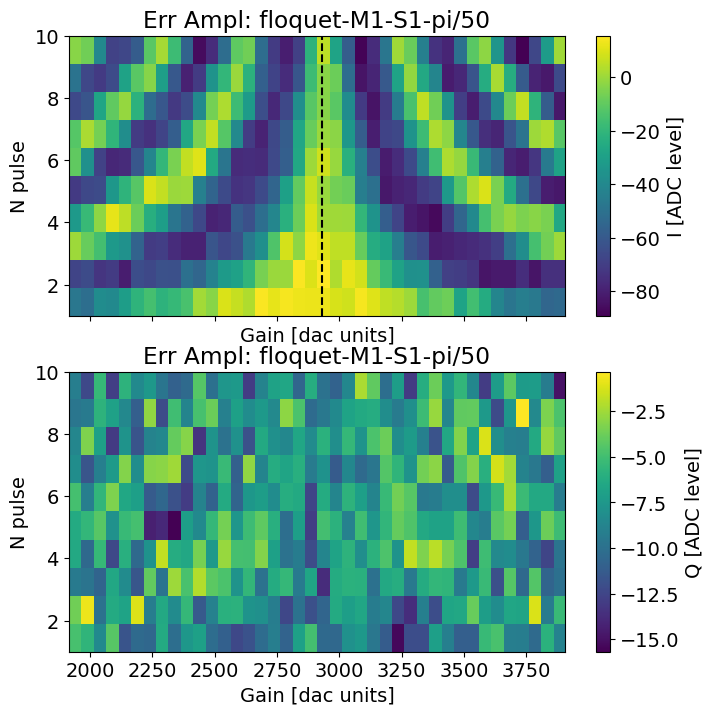

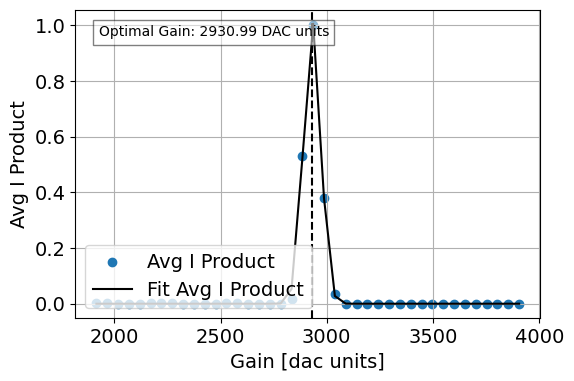

Creating or updating new csv at path: D:\python\multimode_expts\configs\floquet_storage_swap_dataset_new.csv
cfg at start of acquire {'reps': 100, 'rounds': 1, 'qubits': [0], 'active_reset': False, 'man_mode_no': 1, 'stor_is_dump': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'expts': 50, 'n_pulses': 7, 'span': 0.15, 'stor_mode_no': 1, 'parameter_to_test': 'frequency', 'start': 352.73662702894916, 'step': 0.003061224489795918, 'pulse_type': ['floquet', 'M1-S1', 'pi/50', 0]}
n_pts [1 2 3 4 5 6 7]


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00141_ErrorAmplificationExperiment.h5
fitparams [-1.0309244062894127e-05, 1.0000103092440629, 352.81009641670425, 0.014999999999997727]


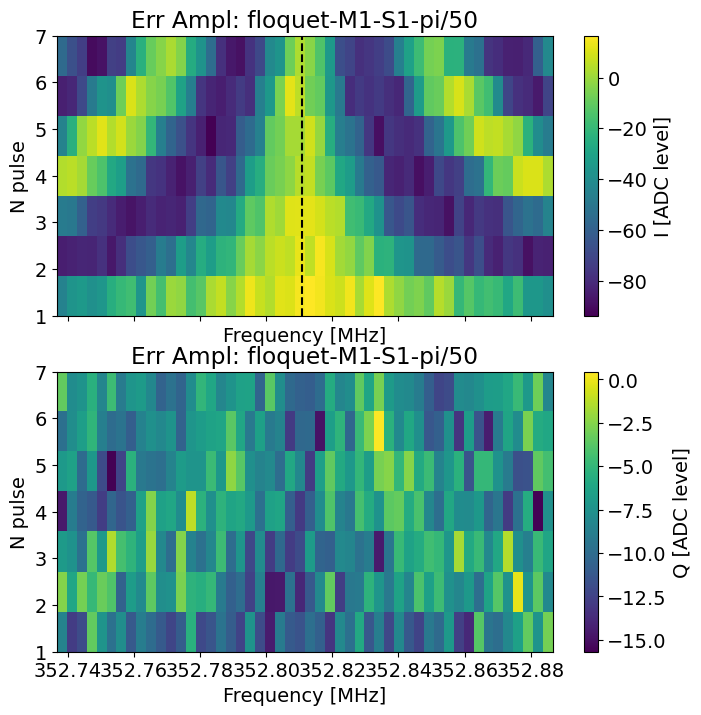

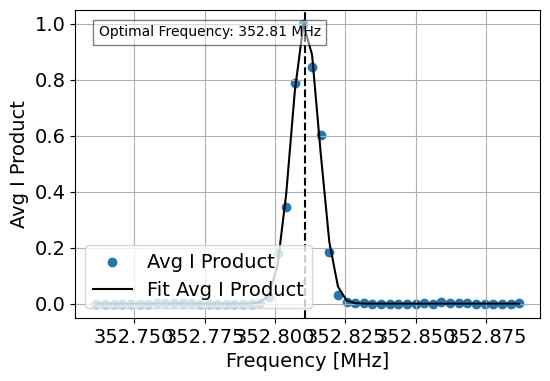

Creating or updating new csv at path: D:\python\multimode_expts\configs\floquet_storage_swap_dataset_new.csv


In [53]:
for i, stor_i in enumerate(stor_modes_to_run):
    stor_name = 'M1-S' + str(stor_i)
    print("Running", stor_name)
    error_amp_gain2[i] = error_amp_floquet_runner.run(
        stor_mode_no=stor_i,
        parameter_to_test='gain',
        go_kwargs=dict(analyze=False, progress=True, display=False),
        **error_amp_gain_floquet_fine_defaults,
    )

    error_amp_freq2[i] = error_amp_floquet_runner.run(
        stor_mode_no=stor_i,
        parameter_to_test='frequency',
        go_kwargs=dict(analyze=False, progress=True, display=False),
        **error_amp_freq_floquet_fine_defaults,
    )

In [54]:
# save new dataset to current_dataset path
station.ds_floquet.save_to_file(
    station.config_dir / station.config_thisrun.device.storage.floquet_man_stor_file
)

Creating or updating new csv at path: D:\python\multimode_expts\configs\floquet_storage_swap_dataset.csv


## Phase accumulation matrix from stark shifts

In [30]:
phase_expts = [[None for _ in range(7)] for _ in range(7)]

In [33]:
stor_modes_to_run = [1,2,3] #list(range(1,8))

for iA, init_storA in enumerate(stor_modes_to_run): #range(1,8):
    for iB, init_storB in enumerate(stor_modes_to_run): #range(1,8):
        if init_storA == init_storB:
            continue
        print("Starting experiment for storage modes:", init_storA, "from", init_storB)
        expt_params = dict(
            expts = 1,
            reps = 100,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  1/2 name of manipulate cavity
            init_stor = 0, # storage mode number to initialize to n=1 Fock state (0 = man)
            ro_stor = 0, # storage mode number that gets read out in the end (0 = man)
            stor_A = init_storA, # storage mode on whose phase accumulation we will evaluate (relative to the stark shifted frequency)
            stor_B = init_storB, # storage mode on which a drive is applied which contributes the phase accumulation
            advance_phases = np.linspace(-10, 10, 21).tolist(),
            n_pulses = np.arange(0, 24, 4).tolist(),
            swept_params = ['n_pulse', 'advance_phase'],
            # usage: if you want to sweep cfg.expt.paramName, 
            # include paramName here in this list 
            # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
            # (You want a list instead of numpy array for better yaml export.)
            # Currently handles 1D and 2D sweeps and plots only.
            # For 2D, order is [outer (y), inner (x)].
            normalize = False, # not sure what this does
            active_reset = False,
            man_reset = True, 
            storage_reset = True, 
            ds_thisrun=ds_thisrun,
            prepulse=True,
            postpulse=True,
        )
        print("phase sweep", expt_params["advance_phases"])
    
        qbe = meas.SidebandStarkAmplificationExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandStarkAmplification_S{expt_params['stor_A']}_S{expt_params['stor_B']}",
            config_file=config_path,
            expt_params=expt_params,
            program=meas.SidebandStarkAmplificationProgram,
            progress=True)
    
        qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
        qbe.go(analyze=False, display=True, progress=True, save=True)
        phase_expts[init_storA - 1][init_storB - 1] = qbe

Starting experiment for storage modes: 1 from 2
phase sweep [-10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

fitparams [0.00018420954051726223, 0.9998157904594828, 3.0, 2.0]


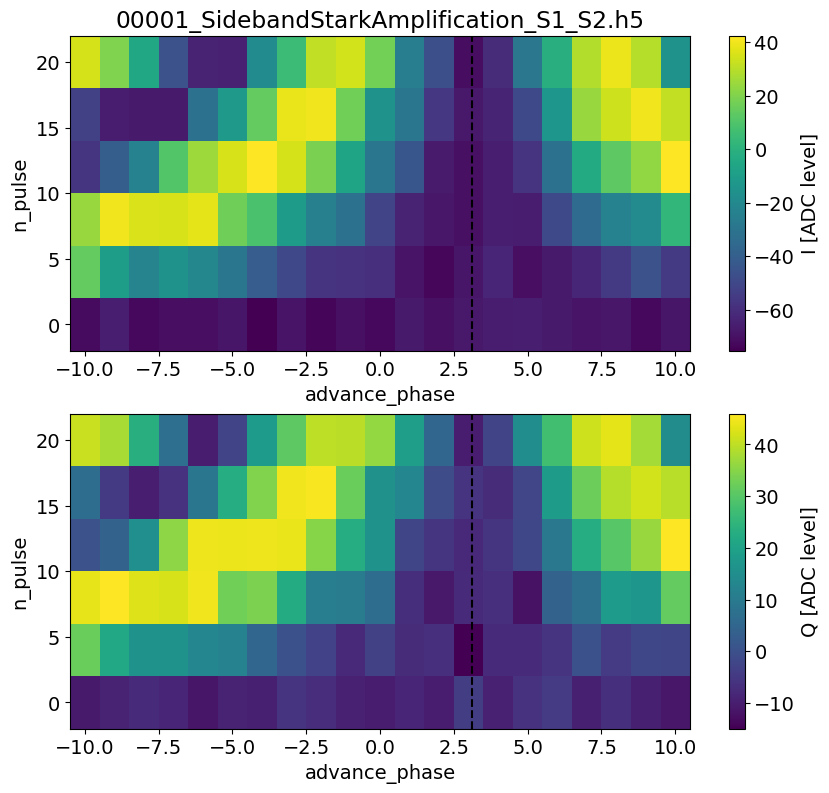

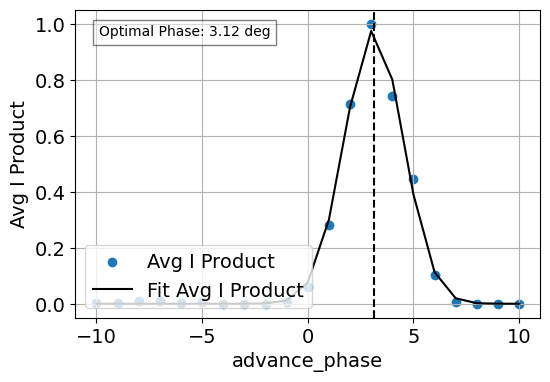

Opt phase on M1-S1 from M1-S2 : 3.124848779259094
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [-0.0011689379974620018, 1.001168937997462, 0.0, 2.0]


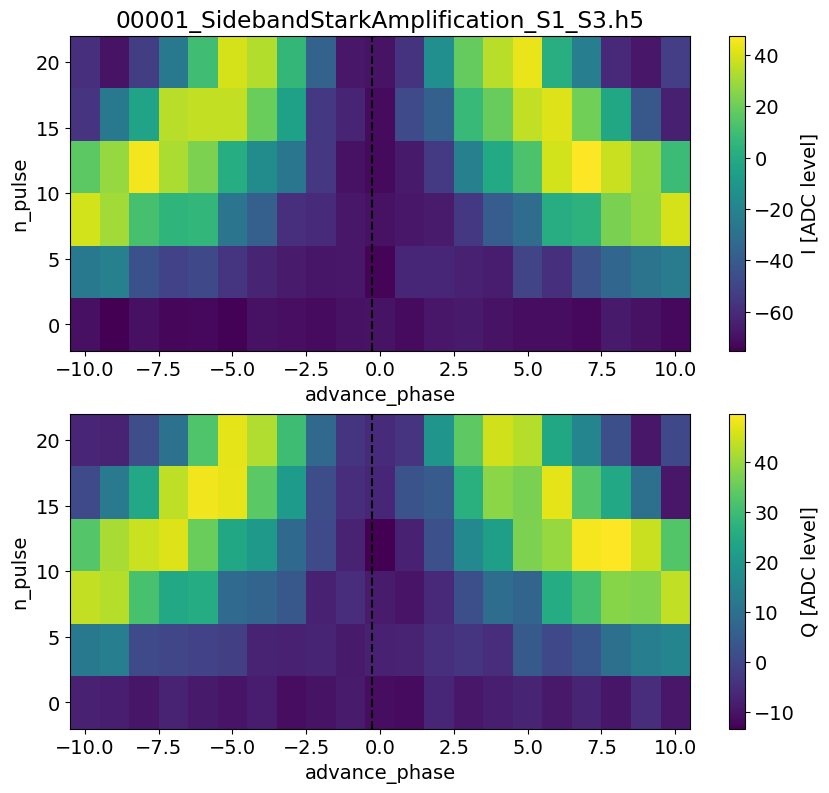

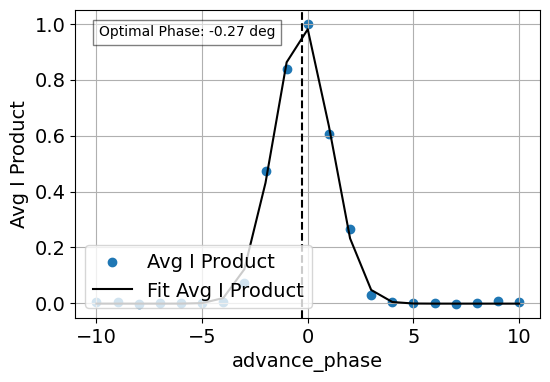

Opt phase on M1-S1 from M1-S3 : -0.27268956879885525
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [-0.0008943371605530673, 1.000894337160553, -3.0, 2.0]


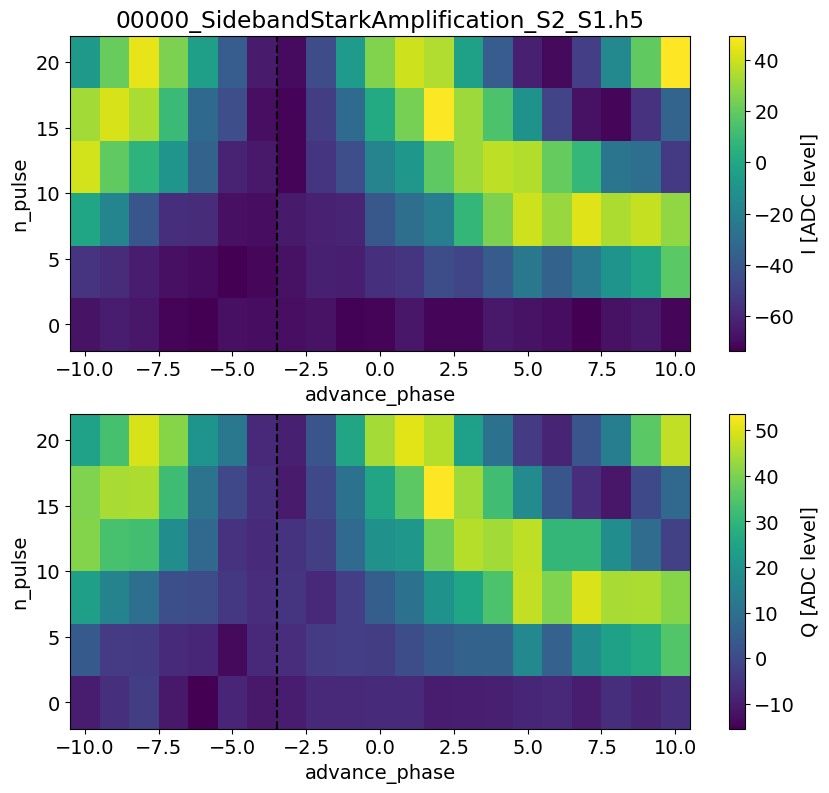

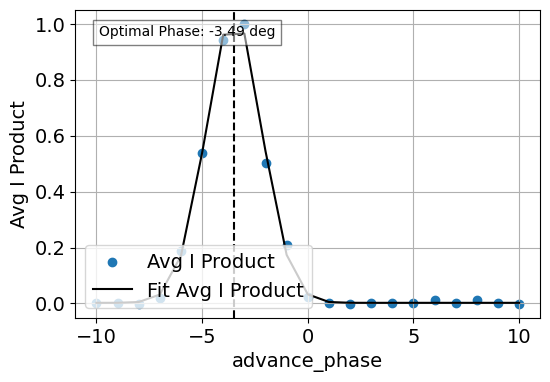

Opt phase on M1-S2 from M1-S1 : -3.4926691594620967
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [-2.72468585149404e-06, 1.0000027246858514, -4.0, 2.0]


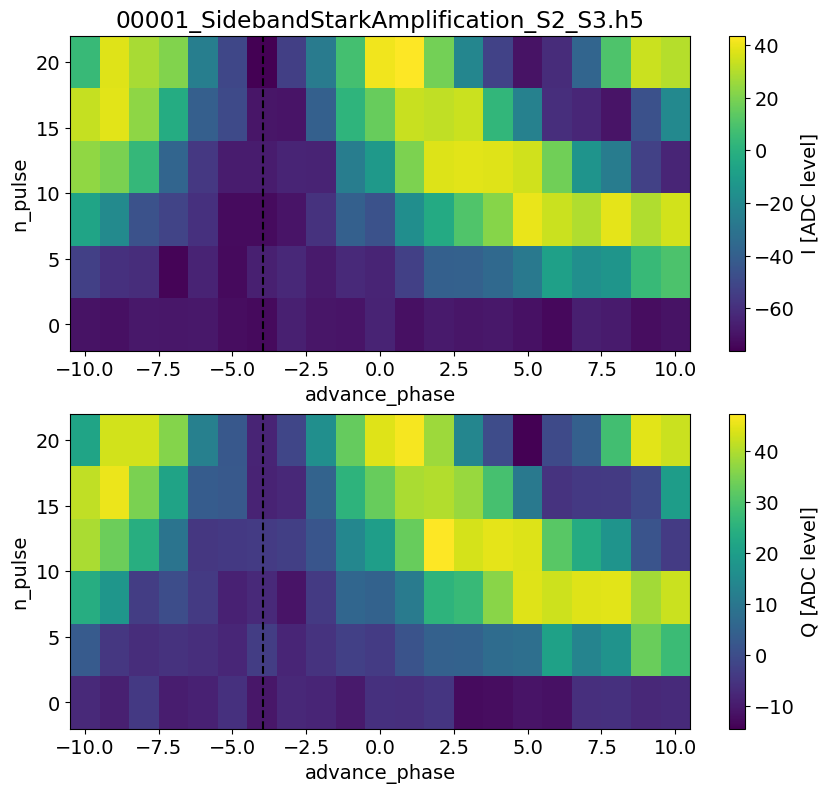

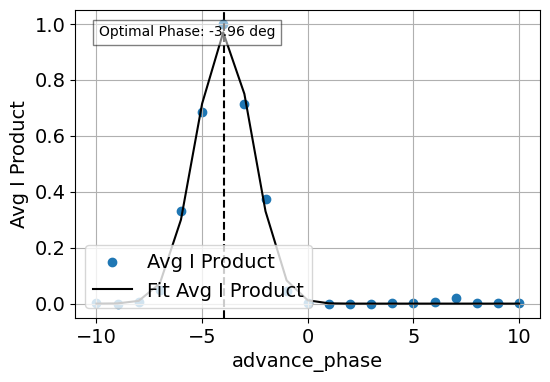

Opt phase on M1-S2 from M1-S3 : -3.9572702657639014
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [-0.0006766561669362328, 1.0006766561669362, 1.0, 2.0]


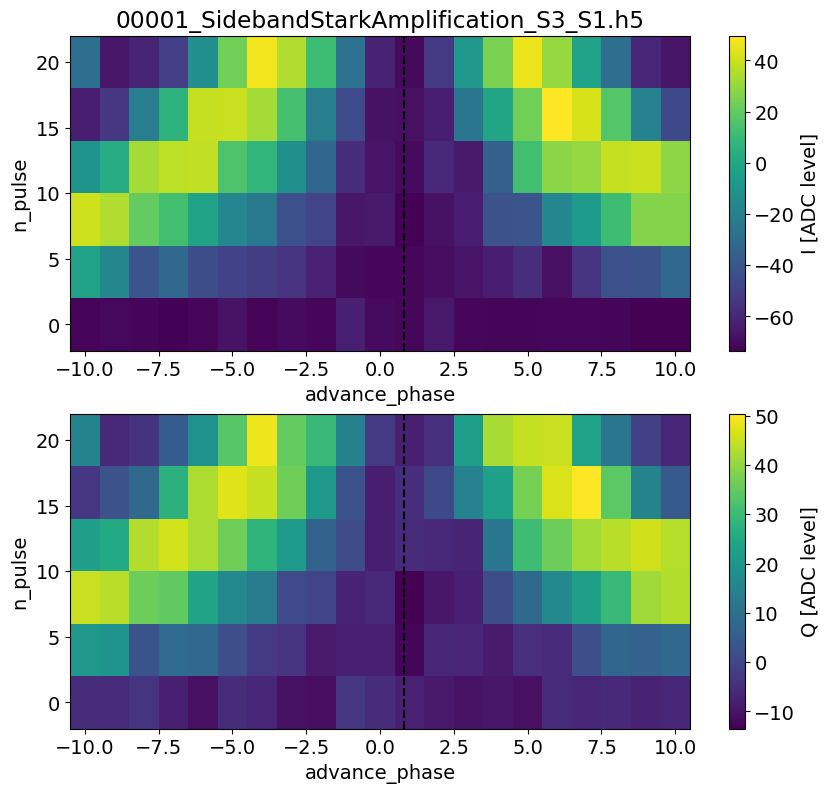

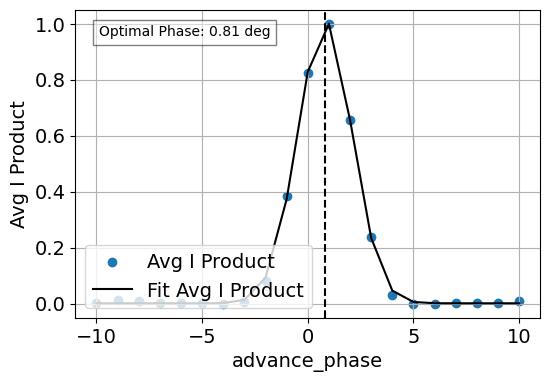

Opt phase on M1-S3 from M1-S1 : 0.8088744580381945
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
fitparams [-0.0011412596008771386, 1.001141259600877, 5.0, 2.0]


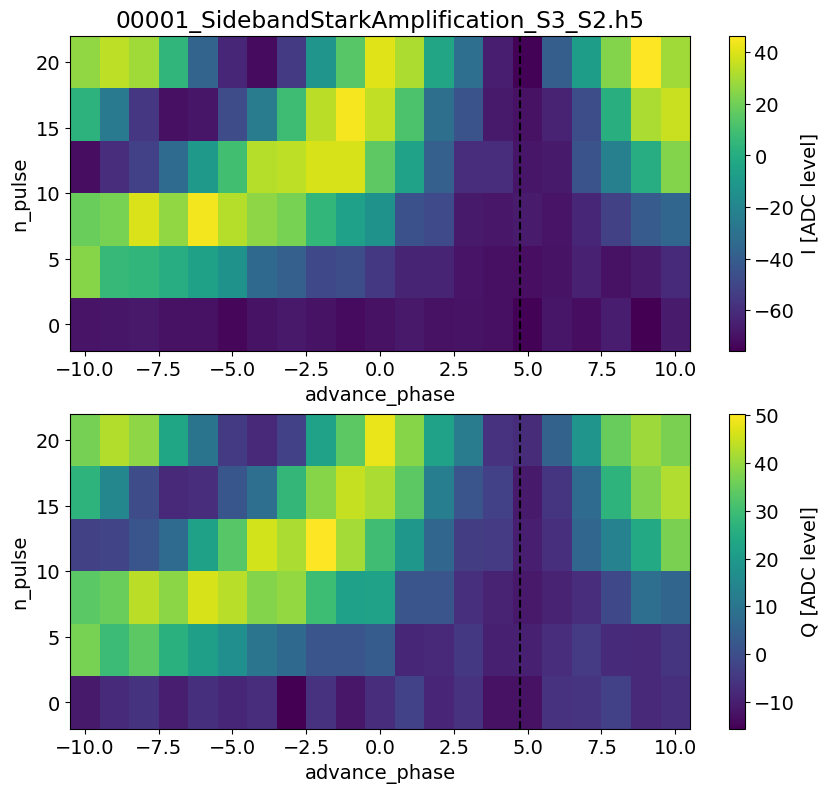

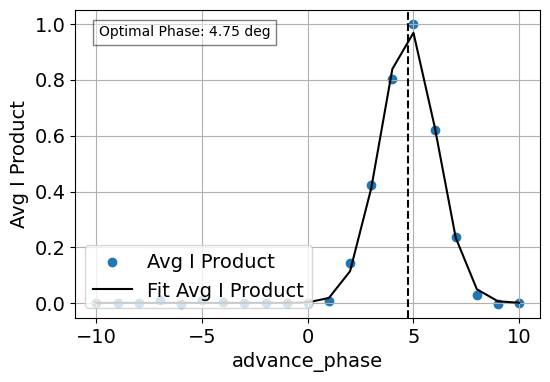

Opt phase on M1-S3 from M1-S2 : 4.753306204569927
Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [34]:
for iA, init_storA in enumerate(stor_modes_to_run): #range(1,8):
    for iB, init_storB in enumerate(stor_modes_to_run): #range(1,8):
        if init_storA == init_storB:
            continue
        stor_name = 'M1-S' + str(init_storA)
        from_stor_name = 'M1-S' + str(init_storB)
        qbe = phase_expts[init_storA - 1][init_storB - 1]
        qbe.analyze(fit=True)
        qbe.display(fit=True)
        # opt_phase = qbe.data['fit_avgi'][2] / 2 # divide by 2 since did pi/12, -pi/12 on the from_stor swap
        opt_phase = qbe.data['fit_avgi'][2] # not dividing seems to give the correct result somehow? to figure out why
        print("Opt phase on", stor_name, "from", from_stor_name, ":", opt_phase)
        ds_thisrun.update_phase_from(stor_name, from_stor_name, opt_phase)

In [35]:
# Save dataset to file
ds.df = ds_thisrun.df.copy()
ds.save_to_file(ds.filename)

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv


In [36]:
ds_thisrun.df

stor_name  pi_frac   freq (MHz)  gain (DAC units)  len (mus)  \
0     M1-S1       50   352.866347              3093   0.038723   
1     M1-S2       30   524.691062              4296   0.063456   
2     M1-S3       40   700.892252              4122   0.046195   
3     M1-S4       30   880.788071              9223   0.051943   
4     M1-S5       30  1057.186387              9987   0.062559   
5     M1-S6       40  1248.880049             13802   0.046533   
6     M1-S7       30  1426.971632              9009   0.114944   

   ramp_sigma (mus)  phase_from_M1-S1 (deg)  phase_from_M1-S2 (deg)  \
0          0.005008                0.000000                3.124849   
1          0.005008               -3.492669                0.000000   
2          0.005008                0.808874                4.753306   
3          0.005008                0.000000                0.000000   
4          0.005008                0.000000                0.000000   
5          0.005008                0.000000                3.591544   
6          0.005008                0.000000                4.529378   

   phase_from_M1-S3 (deg)  phase_from_M1-S4 (deg)  phase_from_M1-S5 (deg)  \
0               -0.272690                     0.0                     0.0   
1               -3.957270                     0.0                     0.0   
2                0.000000                     0.0                     0.0   
3                0.000000                     0.0                     0.0   
4                0.000000                     0.0                     0.0   
5                1.160044                     0.0                     0.0   
6                1.914683                     0.0                     0.0   

   phase_from_M1-S6 (deg)  phase_from_M1-S7 (deg)                 last_update  
0                0.000000                0.000000  2025-12-12 16:34:24.973475  
1               -2.695980               -6.049181  2025-12-12 16:34:25.956365  
2               -0.697611               -2.604314  2025-12-12 16:34:26.954426  
3                0.000000                0.000000  2025-12-12 16:07:23.151804  
4                0.000000                0.000000  2025-12-12 16:07:23.158501  
5                0.000000               -0.994739  2025-12-12 16:07:23.165503  
6                1.045383                0.000000  2025-12-12 16:07:23.172473

In [37]:
ds.df

stor_name  pi_frac   freq (MHz)  gain (DAC units)  len (mus)  \
0     M1-S1       50   352.866347              3093   0.038723   
1     M1-S2       30   524.691062              4296   0.063456   
2     M1-S3       40   700.892252              4122   0.046195   
3     M1-S4       30   880.788071              9223   0.051943   
4     M1-S5       30  1057.186387              9987   0.062559   
5     M1-S6       40  1248.880049             13802   0.046533   
6     M1-S7       30  1426.971632              9009   0.114944   

   ramp_sigma (mus)  phase_from_M1-S1 (deg)  phase_from_M1-S2 (deg)  \
0          0.005008                0.000000                3.124849   
1          0.005008               -3.492669                0.000000   
2          0.005008                0.808874                4.753306   
3          0.005008                0.000000                0.000000   
4          0.005008                0.000000                0.000000   
5          0.005008                0.000000                3.591544   
6          0.005008                0.000000                4.529378   

   phase_from_M1-S3 (deg)  phase_from_M1-S4 (deg)  phase_from_M1-S5 (deg)  \
0               -0.272690                     0.0                     0.0   
1               -3.957270                     0.0                     0.0   
2                0.000000                     0.0                     0.0   
3                0.000000                     0.0                     0.0   
4                0.000000                     0.0                     0.0   
5                1.160044                     0.0                     0.0   
6                1.914683                     0.0                     0.0   

   phase_from_M1-S6 (deg)  phase_from_M1-S7 (deg)                 last_update  
0                0.000000                0.000000  2025-12-12 16:34:24.973475  
1               -2.695980               -6.049181  2025-12-12 16:34:25.956365  
2               -0.697611               -2.604314  2025-12-12 16:34:26.954426  
3                0.000000                0.000000  2025-12-12 16:07:23.151804  
4                0.000000                0.000000  2025-12-12 16:07:23.158501  
5                0.000000               -0.994739  2025-12-12 16:07:23.165503  
6                1.045383                0.000000  2025-12-12 16:07:23.172473

In [70]:
ds.update_phase_from('M1-S2', 'M1-S3', -3.81)
ds.update_phase_from('M1-S2', 'M1-S7', -13.26)
ds.update_phase_from('M1-S3', 'M1-S2', 4.56)
ds.update_phase_from('M1-S3', 'M1-S7', 7.64)
ds.update_phase_from('M1-S7', 'M1-S2', 0.6)
ds.update_phase_from('M1-S7', 'M1-S3', -3.02)
ds.save_to_file('floquet_storage_1Derramp.csv')

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: floquet_storage_1Derramp.csv


In [69]:
ds.update_phase_from('M1-S2', 'M1-S3', -4.4)
ds.update_phase_from('M1-S2', 'M1-S7', -12.34)
ds.update_phase_from('M1-S3', 'M1-S2', 4.07)
ds.update_phase_from('M1-S3', 'M1-S7', 8.56)
ds.update_phase_from('M1-S7', 'M1-S2', 1.24)
ds.update_phase_from('M1-S7', 'M1-S3', -3.02)
ds.save_to_file('floquet_storage_2Derramp.csv')

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv
Creating or updating new csv at path: floquet_storage_2Derramp.csv


# AC Stark calibration with pi/2 dual rail

  0%|          | 0/31 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00000_FloquetPhaseCal_2on3_via1.h5
('Error in saving cfg into datafile (experiment.py):', TypeError('Object of type floquet_storage_swap_dataset is not JSON serializable'))


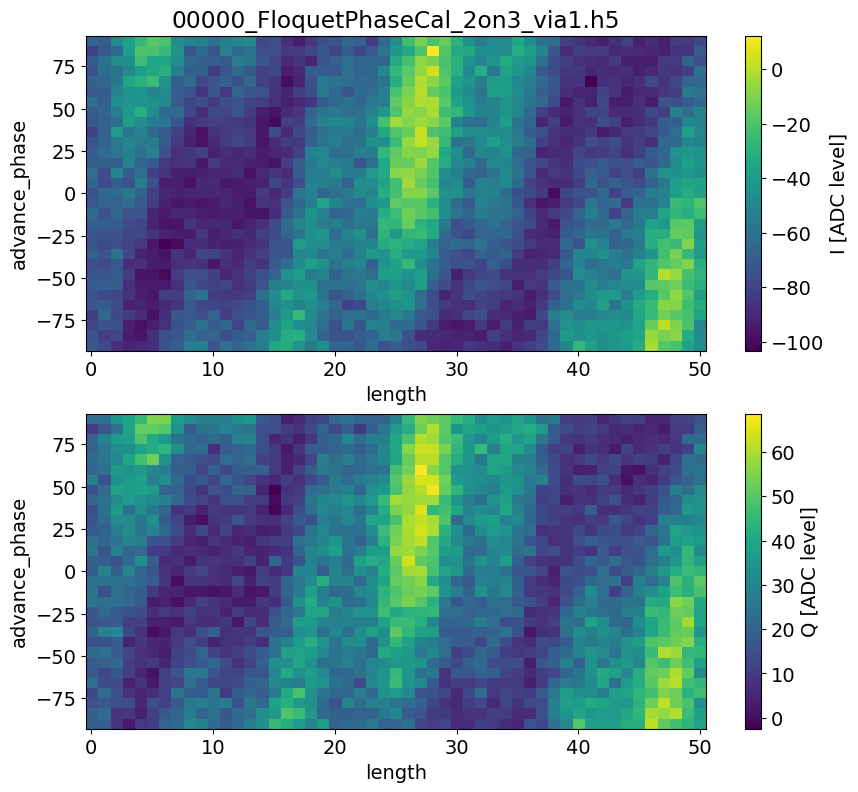

In [25]:
expt_params = dict(
    expts = 1,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 0, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    stor_row = 3,
    stor_col = 2,
    stor_idle = 1,
    # if 0, this means to read out man instead
    # detunes=np.linspace(-0.2, 0.2, 10).tolist(),
    # lengths=np.linspace(0, 1.5 * ds_thisrun.get_len(f'M1-S{init_stor}'), 10).tolist(),
    # swept_params = ['detune', 'length'],
    advance_phases=np.linspace(-90,90,31).tolist(),
    lengths=np.linspace(0.1, 50, 51).tolist(),
    swept_params = ['advance_phase', 'length'],
    # usage: if you want to sweep cfg.expt.paramName, 
    # include paramName here in this list 
    # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
    # (You want a list instead of numpy array for better yaml export.)
    # Currently handles 1D and 2D sweeps and plots only.
    # For 2D, order is [outer, inner].
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    ds_thisrun=ds_thisrun,
)

qbe = meas.FloquetPhaseCalExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetPhaseCal_{expt_params['stor_col']}on{expt_params['stor_row']}_via{expt_params['stor_idle']}",
    config_file=config_path,
    expt_params=expt_params,
    program=meas.FloquetPhaseCalProgram,
    progress=True)

qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
qbe.go(analyze=False, display=True, progress=True, save=True)
# freq_len_expt[i] = qbe

## Use the period of the 2 storage + M1 random walk to error amplify the phase calibration

In [ ]:
# storA = 2
# storB = 3

for storA, storB in [(2,3),(2,6),(3,6),(2,7),(3,7),(6,7)]:
    print("Starting experiment for storage modes:", storA, "from", storB)
    n_scramble_cycles = [0,1,2,3]
    pifracA, pifracB = ds_thisrun.get_pi_frac(f'M1-S{storA}'), ds_thisrun.get_pi_frac(f'M1-S{storB}')
    n_floquet_per_scramble = int(np.round(2*(pifracA**2 + pifracB**2)**0.5))
    # = for omega1=omega2 the period is 2sqrt(2) * pi_frac

    floquet_cycles = n_floquet_per_scramble * n_scramble_cycles

    expt_params = dict(
        expts = 1,
        reps = 50,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = storA, # storage mode number to initialize to n=1 Fock state (0 = man)
        ro_stor = storB, # storage mode number that gets read out in the end (0 = man)
        storA = storA, # storage mode on whose phase accumulation we will evaluate (relative to the stark shifted frequency)
        storB = storB, # storage mode on which a drive is applied which contributes the phase accumulation
        storA_advance_phases = np.linspace(-15, 15, 61).tolist(),
        storB_advance_phases = np.linspace(-15, 15, 61).tolist(),
        n_scramble_cycles = n_scramble_cycles,
        n_floquet_per_scramble = n_floquet_per_scramble,
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer (y), inner (x)].
        normalize = False, # not sure what this does
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        ds_thisrun=ds_thisrun,
        prepulse=True,
        postpulse=True,
    )
    print("n_scramble_cycles", expt_params["n_scramble_cycles"])
    print("phase sweep A", expt_params["storA_advance_phases"])
    print("phase sweep B", expt_params["storB_advance_phases"])

    qbe = meas.FloquetCalibrationAmplificationExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"FloquetCalibrationAmplificationExperiment_S{expt_params['storA']}_S{expt_params['storB']}",
        config_file=config_path,
        expt_params=expt_params,
        program=meas.FloquetCalibrationProgram,
        progress=True)

    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.acquire(progress=True, debug=True)
    qbe.save_data()

Starting experiment for storage modes: 2 from 3
n_scramble_cycles [0, 1, 2, 3]
phase sweep A [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
phase sweep B [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
Starting experiment for n_scramble_cycle 0 with total floquet cycles 100


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 1 with total floquet cycles 300


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 2 with total floquet cycles 500


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 3 with total floquet cycles 700


  0%|          | 0/61 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00000_FloquetCalibrationAmplificationExperiment_S2_S3.h5
Starting experiment for storage modes: 2 from 6
n_scramble_cycles [0, 1, 2, 3]
phase sweep A [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
phase sweep B [-15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]
Starting experiment for n_scramble_cycle 0 with total floquet cycles 100


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experiment for n_scramble_cycle 1 with total floquet cycles 300


  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
qbe.save_data()
# qbe.analyze()

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00000_FloquetCalibrationAmplificationExperiment_S1_S2.h5


array([1])

# Qsim

## Initial random try

In [24]:
import multimode_expts.experiments.qsim.qsim_experiments as qsim_exp

experiment_name = 'storage_sweep'

flqSwap = qsim_exp.floquet_swap_class(
    soccfg=soc, 
    path=expt_path, 
    prefix=experiment_name, 
    config_file=config_path, 
    exp_param_file=os.path.join(curr_path, 'configs', 'qsim_exp_cfg.yml')
)

flqSwap.run_sweep( sweep_experiment_name = experiment_name)

Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}


  0%|          | 0/7 [00:00<?, ?it/s]

[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8

## Sideband Ramsey

This is starting to test our channel phases: when we switch from one channel generator freq to diff freq (activating different storage swaps), does our code preserve phase coherence between the successive (partial) pulses. 

We start from a simple M1-Sx Ramsey: qubit ge, qubit ef, f0g1 to initialize man1 into |1>, then do pi/2 on the beam splitter and wait and another pi/2.

In [72]:
from multimode_expts.experiments.qsim.sideband_ramsey_scramble import SidebandRamseyExperiment

In [24]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandRamseyExperiment

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_SidebandRamsey_M1S1.h5
Current pi pulse frequency: 3571.709750355705
Fit frequency from I [MHz]: 0.3089569532058502 +/- 0.0008688187687284037
Suggested new pi pulse frequency from fit I [MHz]:
 	3571.600793402499
 	3572.2187073089112
T2 Ramsey from fit I [us]: 151.35019342478705
Fit frequency from Q [MHz]: 0.3081087340680849 +/- 0.0012433866916204631
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3571.601641621637
 	3572.2178590897734
T2 Ramsey from fit Q [us]: 91.19102876798401


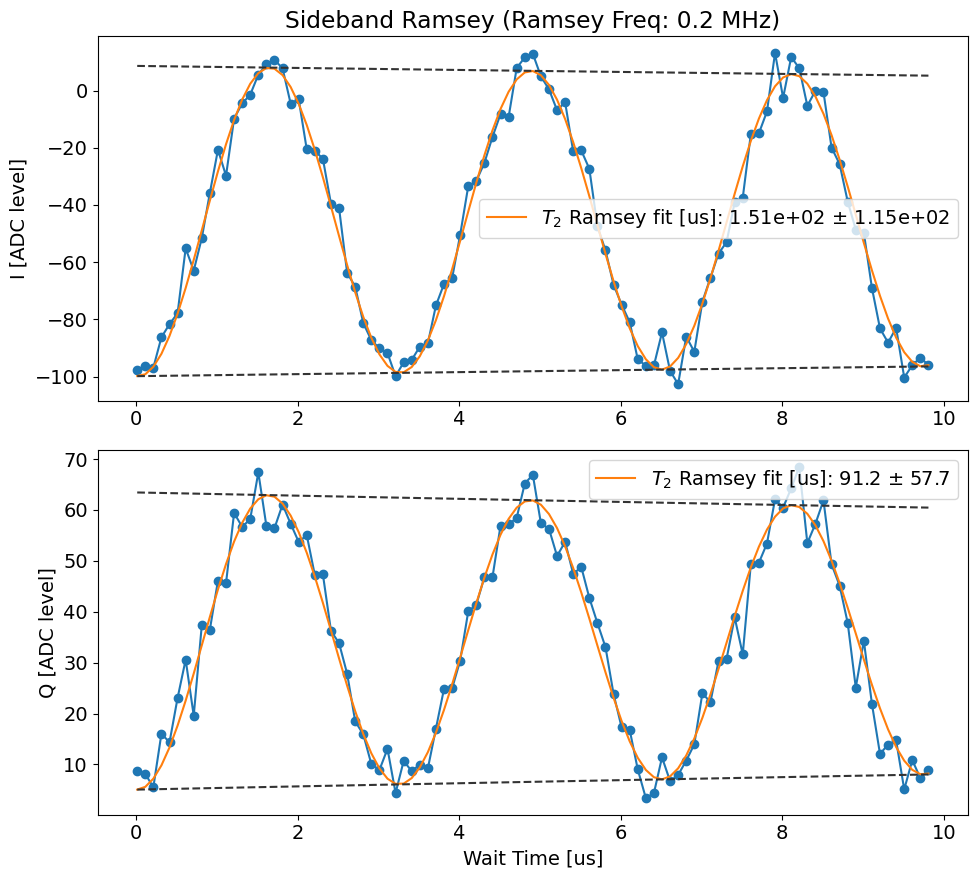

In [27]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.1,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.2, # [MHz]
    detune = 0,
    ac_stark=0.5, # [MHz] not sure how to define sign yet
    # but in any case this needs to be smaller than ramsey_freq
    # because qick can't handle negative numbers
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = True,
    man_reset = True, 
    storage_reset = True, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

sbr = SidebandRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandRamsey_M1S{expt_params['stor_no']}",
    config_file=config_path,
    expt_params = expt_params,
    progress=True)

sbr.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
# sbr.acquire()
sbr.go(analyze=True, display=True, progress=True, save=True)

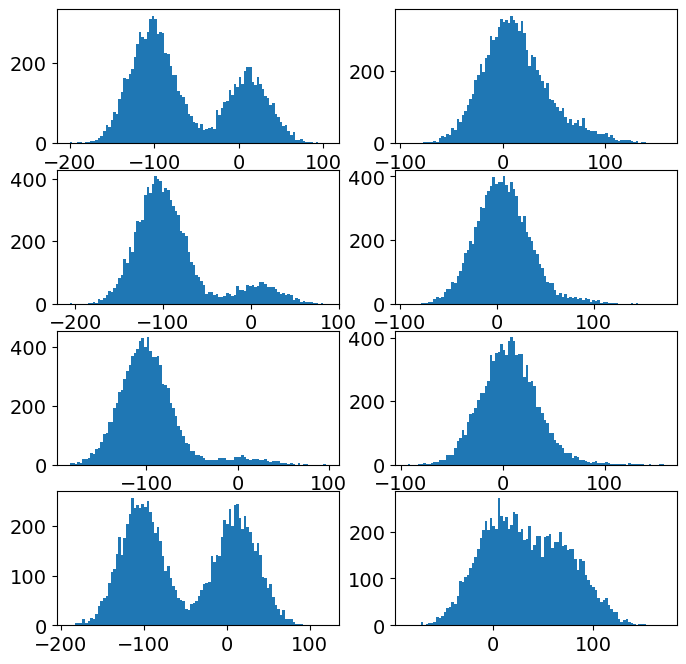

In [28]:
idata = sbr.data['idata']
idata = idata.reshape((len(idata)//4,4))

qdata = sbr.data['qdata']
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

In [ ]:
0.327922332524605 # current reset version
0.32806373843420333 # without reset
0.3264759424279595 # reset with 100us wait
0.3274569103286323 # only 0 to N+1
0.328382941835013 # only -N to 0
0.327225195204317 # only 0
0.325693135972055 # n set to 30
0.32566986782848 # add 100 to m1d1

### 2D chevron

In [32]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandChevronExperiment

In [33]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.05,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.1, # [MHz]
    ac_stark=0.5,
    detune = 0,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = False,
    # man_reset = False, 
    # storage_reset = False, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

for stor_no in [5]: #range(1,8):
    expt_params['stor_no'] = stor_no
    sbr = SidebandChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandChevron_M1S{stor_no}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    # sbr.acquire()
    sbr.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [85]:
sbr.data.keys()

dict_keys(['avgi', 'avgq', 'amps', 'phases', 'idata', 'qdata', 'xpts', 'ypts'])

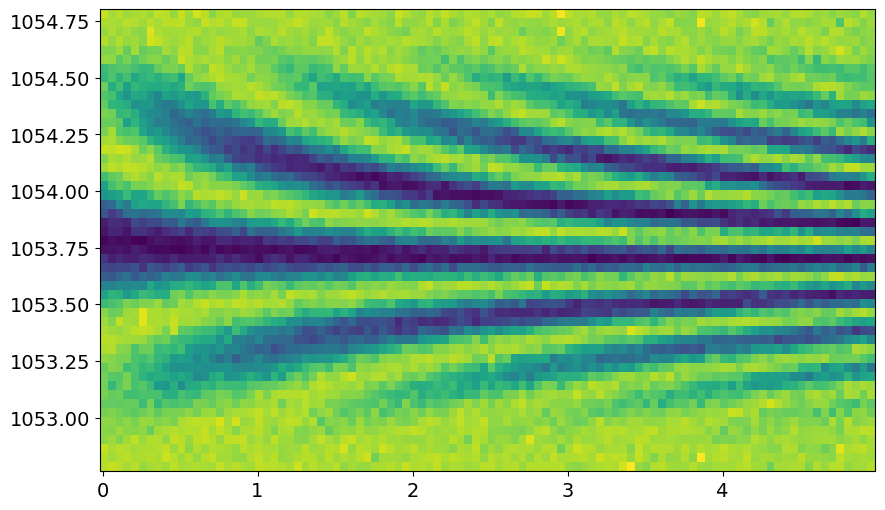

In [ ]:
plt.pcolormesh(sbr.data['xpts'], sbr.data['ypts'], sbr.data['avgi'])

## Sideband scramble

In [20]:
from multimode_expts.experiments.qsim.sideband_scramble import SidebandScrambleProgram

  0%|          | 0/501 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00028_SidebandScramble_S0_to_S0.h5


  0%|          | 0/501 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00003_SidebandScramble_S0_to_S1.h5


  0%|          | 0/501 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00002_SidebandScramble_S0_to_S2.h5


  0%|          | 0/501 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00003_SidebandScramble_S0_to_S3.h5


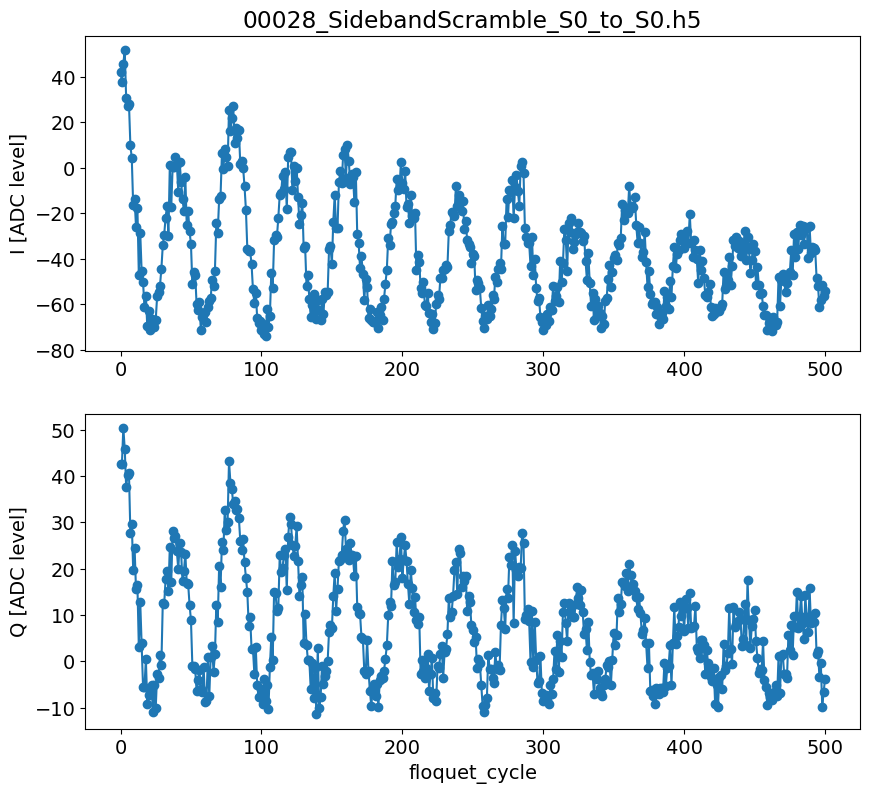

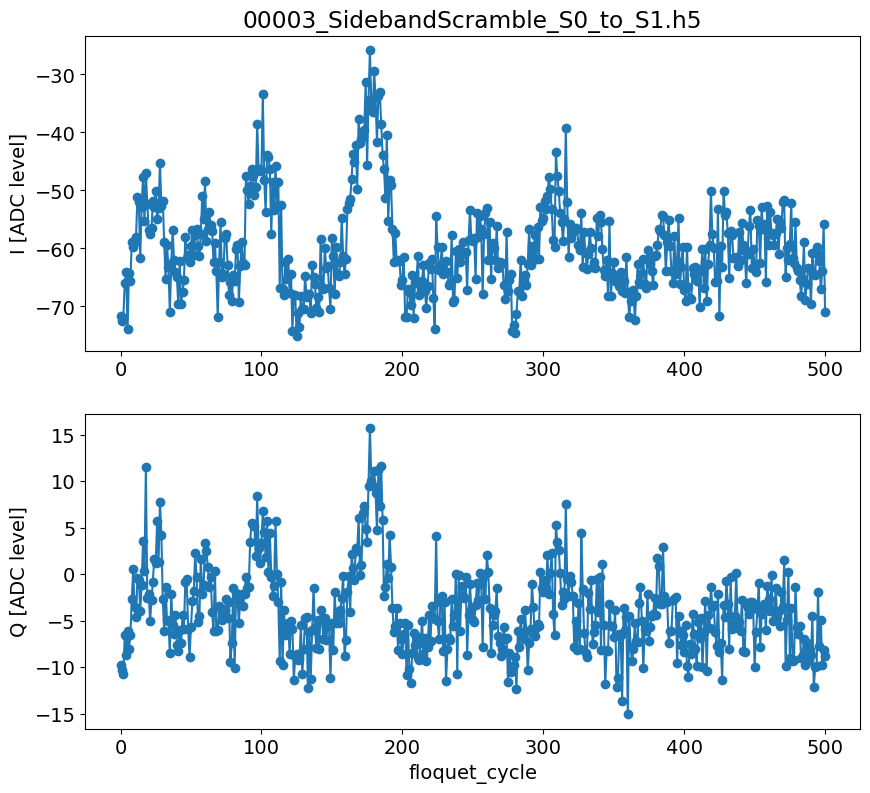

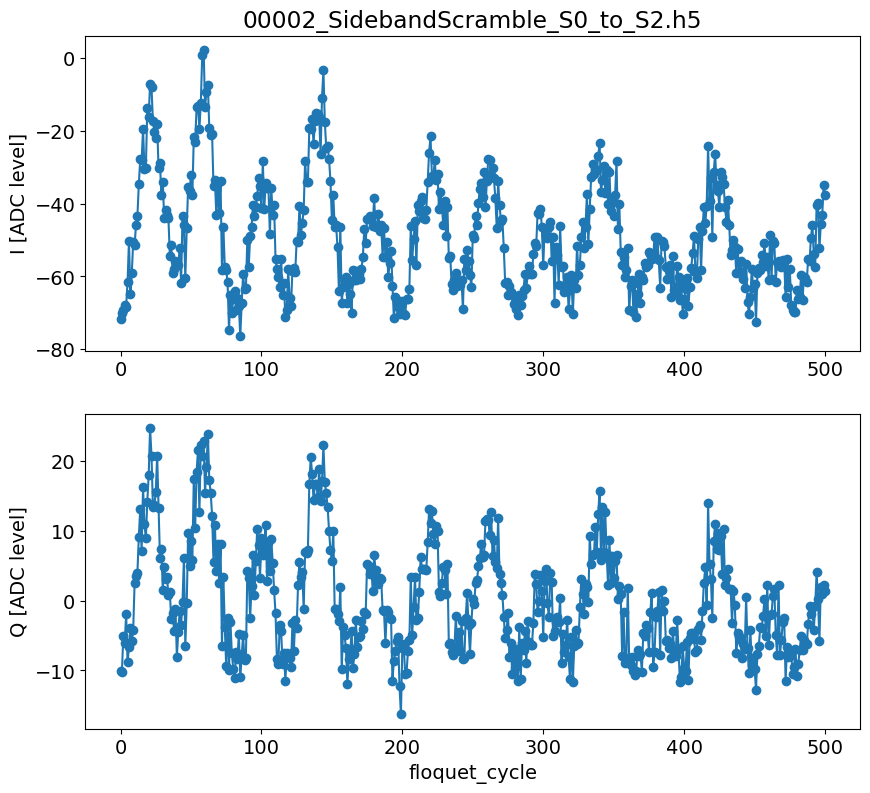

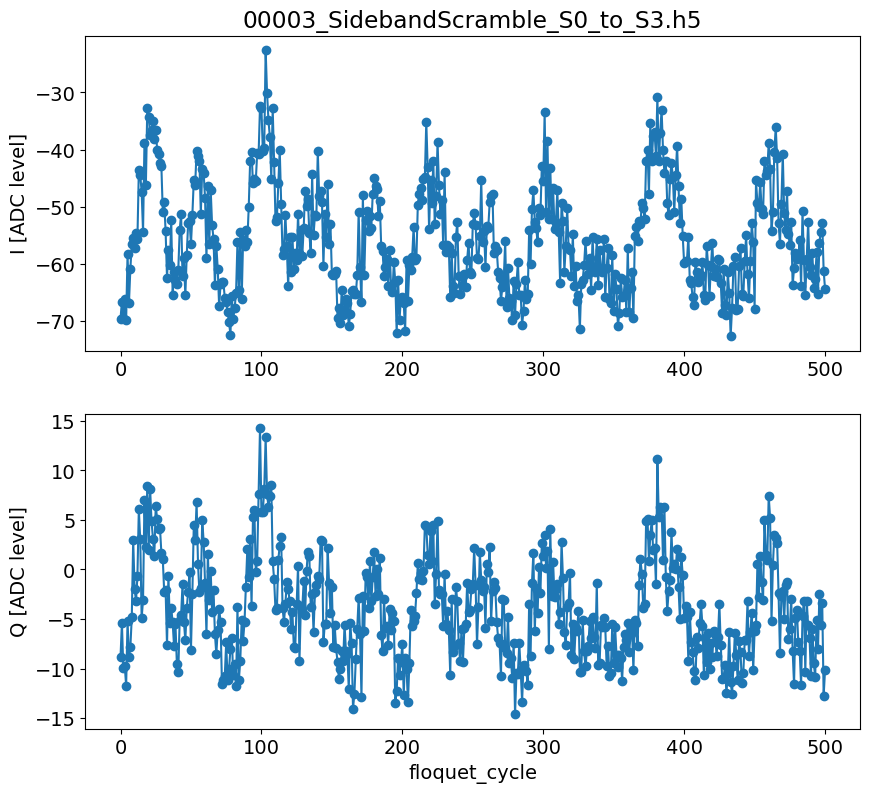

In [40]:
meas_stors = [0,1,2,3]

for update_phases in [True]: # [False, True]:
    for meas_stor in meas_stors:
        expt_params = dict(
            expts = 1,
            reps = 100,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  name of manipulate cavity (1 or 2)
            init_stor = 0, # storage mode number to initialize to n=1 Fock state
            ro_stor = meas_stor, # storage mode number that gets read out in the end
            # if 0, this means to read out man instead
            floquet_cycles = list(range(0,501)),
            detune=0,
            normalize = False,
            active_reset = False,
            man_reset = True, 
            storage_reset = True, 
            # advance_phase=3,
            # swept_params = ['advance_phase', 'floquet_cycle'],
            swept_params = ['floquet_cycle'],
            swap_stors = [1,2,3],
            # floquet_dataset_filename = 'floquet_storage_2Derramp.csv',
            update_phases = update_phases, 
            echoes = [False, 0], # [on/off, number of echoes]
            prepulse=True,
            postpulse=True,
        )
    
        sbs = meas.QsimBaseExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
            config_file=config_path,
            expt_params = expt_params,
            program = meas.SidebandScrambleProgram,
            progress=True)
    
        sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
        sbs.go(analyze=False, display=True, progress=True, save=True)

### readout cavity freq sweep at the end

In [43]:
expt_params = dict(
    expts = 1,
    reps = 100,
    rounds = 1000,
    qubits = [0],
    f0g1_cavity = 1,  #  name of manipulate cavity (1 or 2)
    init_stor = 0, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycle = 300,
    detune=0,
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    swept_params = ['readout_freq'],
    readout_freqs = np.linspace(748,751,101).tolist(),
    swap_stors = [1,3],
    # floquet_dataset_filename = 'floquet_storage_2Derramp.csv',
    update_phases = True, 
    echoes = [False, 0], # [on/off, number of echoes]
    prepulse=True,
    postpulse=False,
)

sbs = meas.QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = meas.ReadoutFreqSweepProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
print(sbs.prog.asm())


// Program

        regwi 3, $12, 466865980;                //freq = 466865980
        regwi 3, $13, 307736202;                //phase = 307736202
        regwi 3, $15, 800;                      //gain = 800
        regwi 3, $16, 590469;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 645 
        synci 86;
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 99;
LOOP_J: regwi 1, $22, 599114555;                //freq = 2396458223
        bitwi 1, $22, $22 << 2;
        mathi 1, $22, $22 + 3;
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 0;                        //gain = 0
        regwi 1, $26, 1638410;                  //phrst| stdysel | mode | | outsel = 0b11001 | length = 10 
        regwi 1, $27, 0;                        //t = 0
        set 2, 1, $22, $23, $0, $25, $26, $27;  //ch = 2, pulse @t = $27
        regwi 2, $12, 840205128;                //freq = 3360820513
        bitwi 2, $12, $12 << 2;
       

In [47]:
sbs.prog.cycles2us(10)

0.023251488095238096

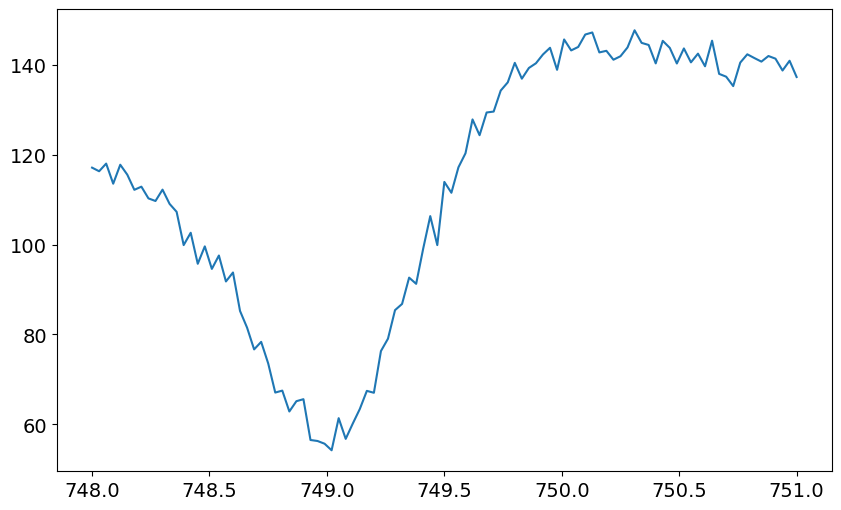

In [28]:
plt.plot(sbs.data['xpts'], sbs.data['amps'])

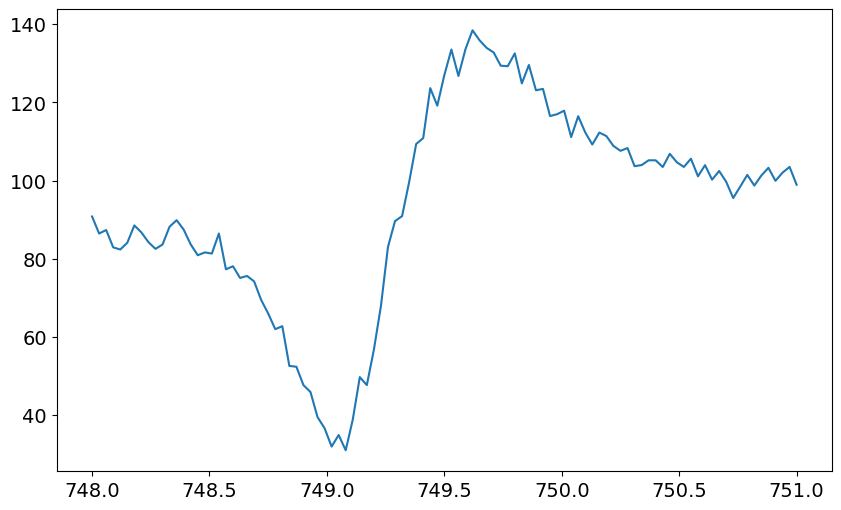

In [ ]:
plt.plot(sbs.data['xpts'], sbs.data['amps'])

  0%|          | 0/101 [00:00<?, ?it/s]

[749.5, 5000, 1000, 0, 186.6986454765322, 185.29089093262422, -17.801072631674074]
[ 749.5897569  -463.55334141  749.08881999    1.72509378  115.29696424
  355.45349252   13.87285143]

Freq with minimum transmission: 750.13
Freq with maximum transmission: 749.47
From fit:
	f0: 749.5897568952053
	Qi: -463.553341408016
	Qe: 749.0888199949264
	Q0: -1216.1102614586064
	kappa [MHz]: -0.6163830539478756
	phi [radians]: 1.7250937755892433
Saving D:\experiments\251031_qsim\data\00008_ResonatorSpectroscopyExperiment.h5


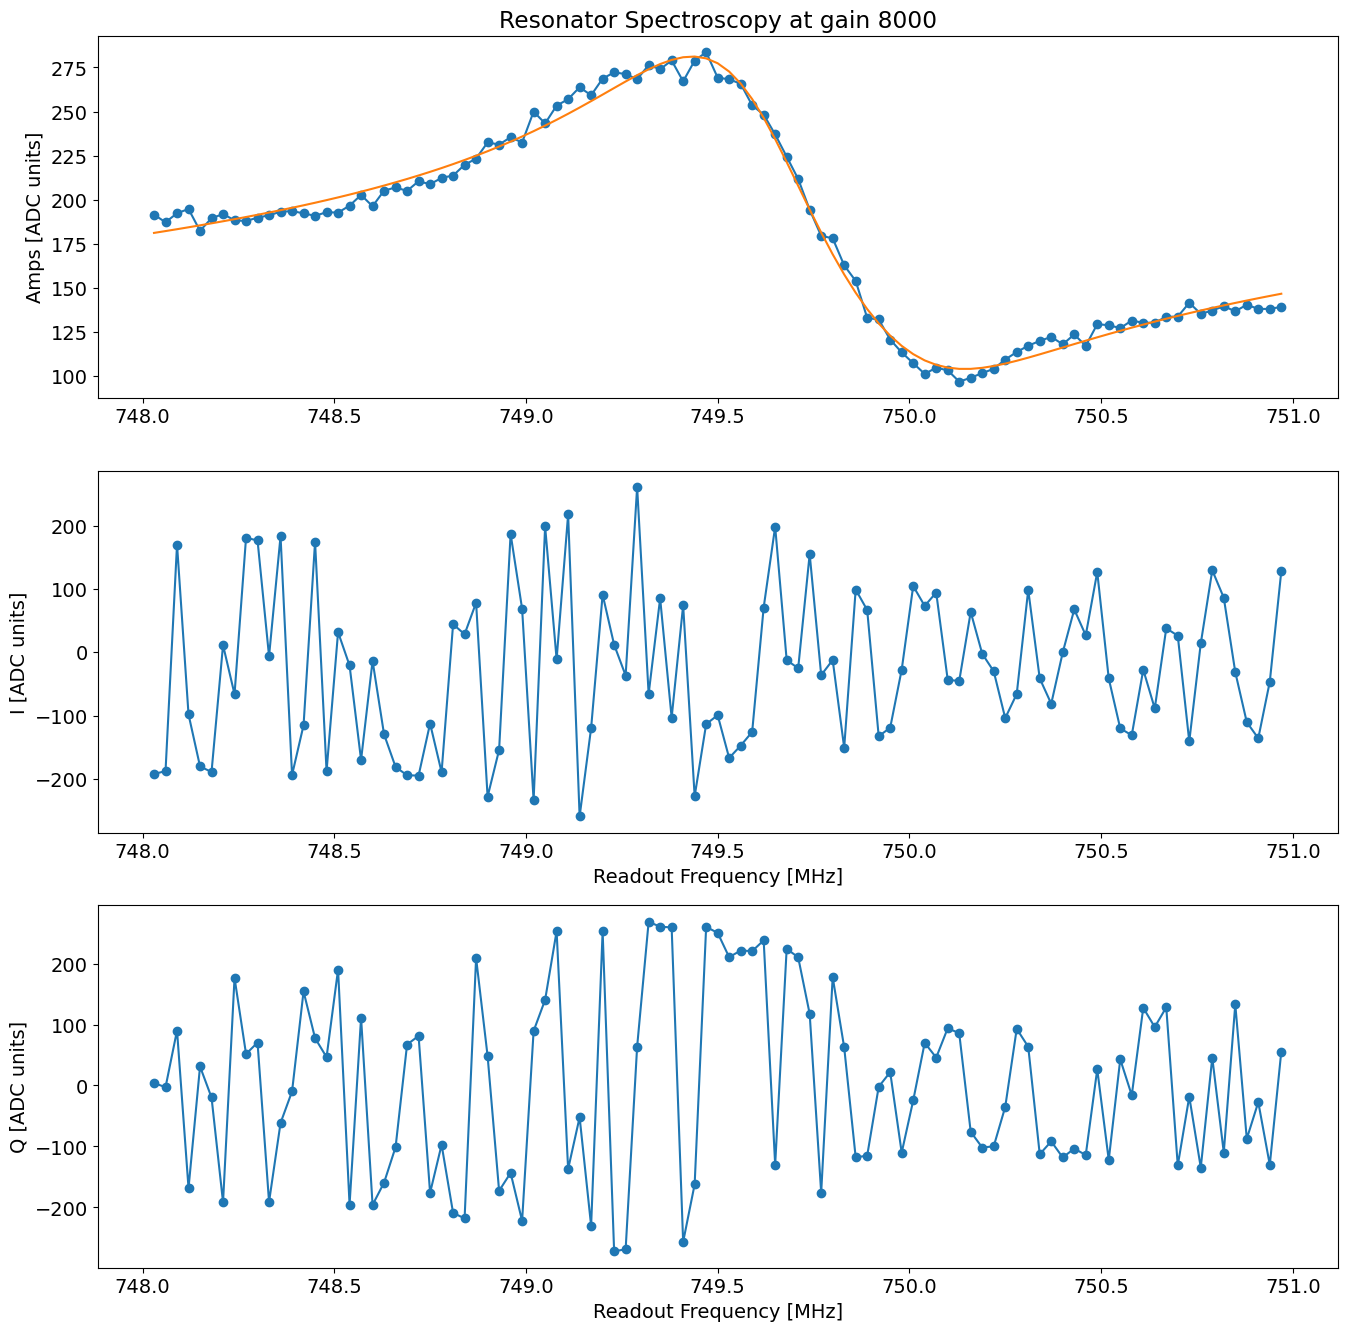

In [41]:
rspec = meas.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )
rspec.cfg = AttrDict(deepcopy(config_thisrun))

rspec.cfg.expt = dict(
    start = 748, # resonator frequency to be mixed up [MHz]
    step = 0.03,
    expts = 101, # Number experiments stepping from start
    reps = 100, # Number averages per point
    pulse_e = True, # add ge pi pulse prior to measurement
    pulse_f = False, # add ef pi pulse prior to measurement
    pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
    cavity_pulse = [4984.373226159381, 800, 2, 0], # [frequency, gain, length, phase]  const pulse
    qubit = 0,
)

rspec.cfg.device.readout.gain = [8000]
rspec.cfg.device.readout.relax_delay = [800] # Wait time between experiments [us]
rspec.go(analyze=True, display=True, progress=True, save=True)

### Phase calibration using quantum walk

In [92]:
from multimode_expts.experiments.qsim.sideband_scramble import FloquetCalibrationProgram

In [ ]:
storA = 2
storB = 3

expt_params = dict(
    expts = 1,
    reps = 50,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    storA = storA,
    storB = storB,
    init_stor = storA, # storage mode number to initialize to n=1 Fock state
    ro_stor = storB, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,201,2)), 
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    storA_advance_phases = np.linspace(-20,20,81).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    storB_advance_phase = ds_thisrun.get_phase_from(f'M1-S{storB}', f'M1-S{storA}')*2,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['storA_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
    prepulse=True,
    postpulse=True
)


fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
for storA, storB in [(2,6),(2,7),(3,2),(3,6),(3,7),(6,2),(6,3),(6,7),(7,2),(7,3),(7,6)]:
    expt_params = dict(
        expts = 1,
        reps = 50,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        storA = storA,
        storB = storB,
        init_stor = storA, # storage mode number to initialize to n=1 Fock state
        ro_stor = storB, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        floquet_cycles = list(range(1,201,5)), 
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        storA_advance_phases = np.linspace(-20,20,41).tolist(), # advance phase of each successive pulse for the init mode[degrees]
        storB_advance_phase = ds_thisrun.get_phase_from(f'M1-S{storB}', f'M1-S{storA}')*2,
        # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
        swept_params = ['storA_advance_phase', 'floquet_cycle'],
        # swept_params = ['floquet_cycle'],
        echoes = [False, 0], # [on/off, number of echoes]
        prepulse=True,
        postpulse=True
    )
    
    
    fce = QsimBaseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        program = FloquetCalibrationProgram,
        progress=True)
    
    fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    fce.go(analyze=False, display=True, progress=True, save=True)

(<Figure size 1000x900 with 4 Axes>,
 array([<Axes: title={'center': '00002_FloquetCalibration_S2_to_S3.h5'}, xlabel='floquet_cycle', ylabel='storA_advance_phase'>,
        <Axes: xlabel='floquet_cycle', ylabel='storA_advance_phase'>],
       dtype=object))

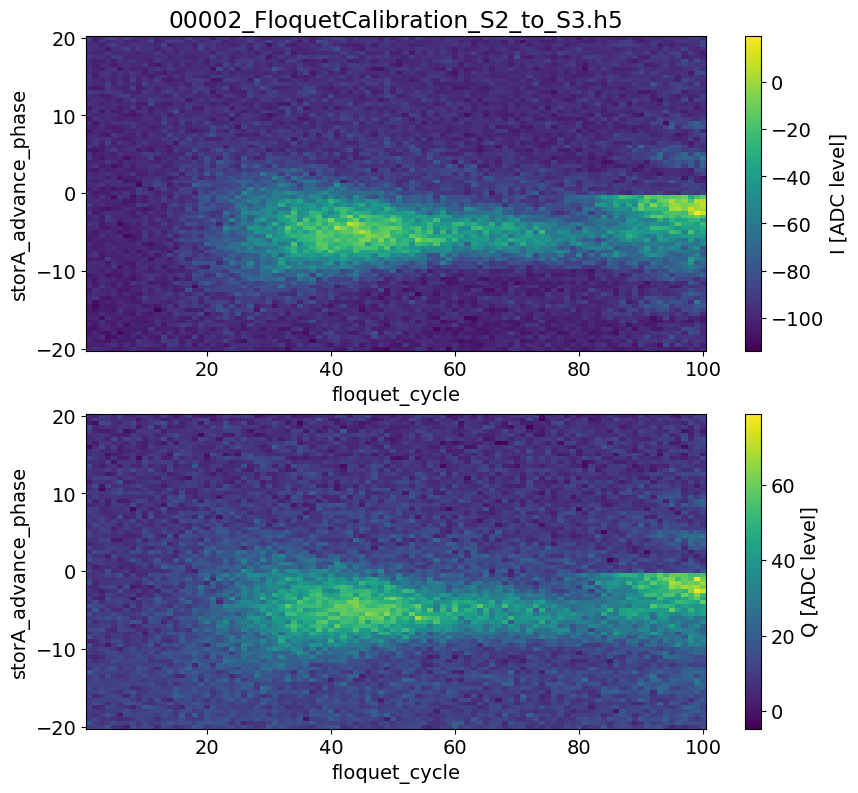

In [105]:
fce.display()

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S3_to_S1.h5


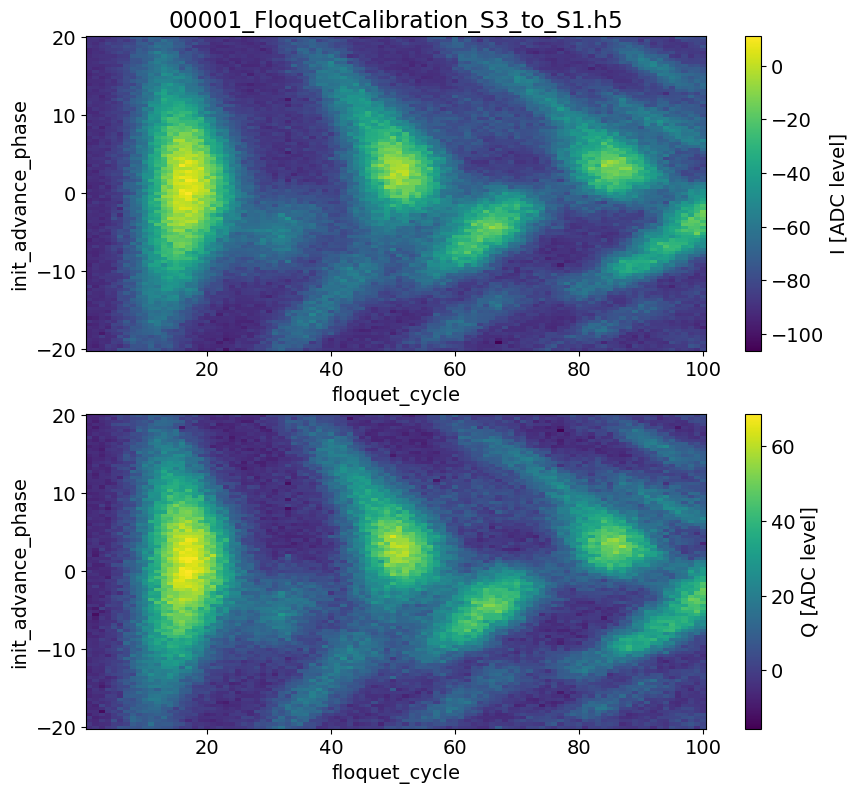

In [51]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 3, # storage mode number to initialize to n=1 Fock state
    ro_stor = 1, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = -4,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S2_to_S3.h5


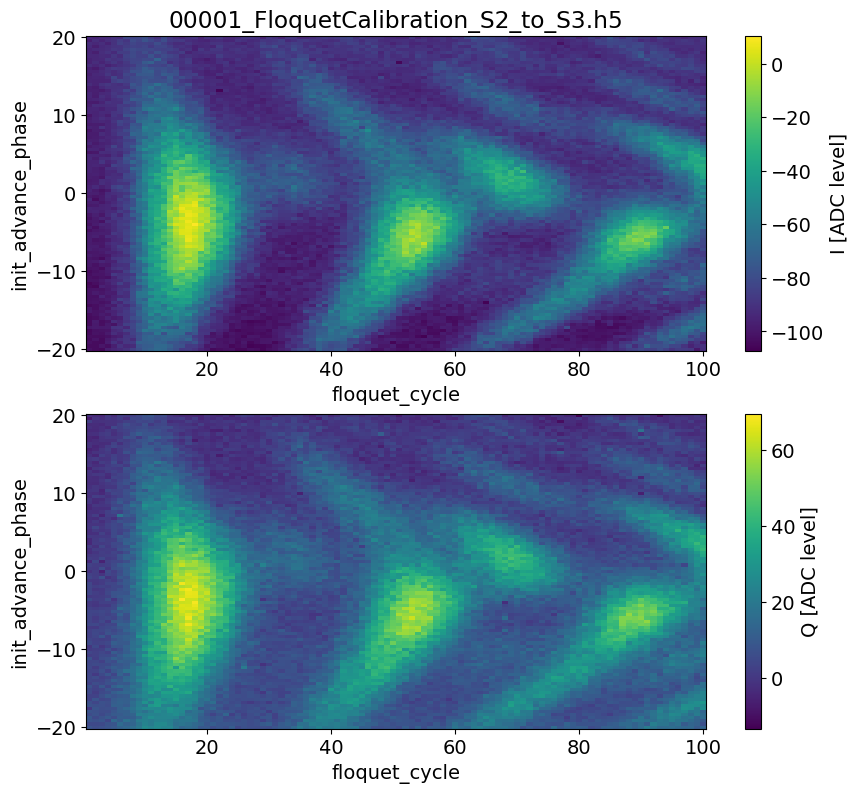

In [60]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 2, # storage mode number to initialize to n=1 Fock state
    ro_stor = 3, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = 6,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00001_FloquetCalibration_S3_to_S2.h5


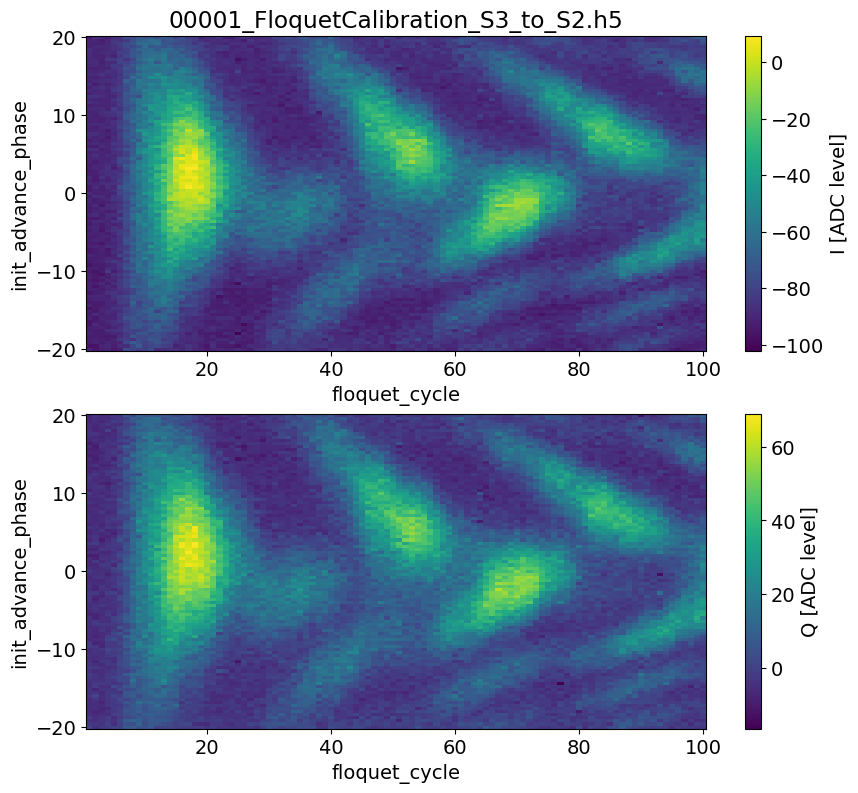

In [61]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 3, # storage mode number to initialize to n=1 Fock state
    ro_stor = 2, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = np.linspace(-20,20,101).tolist(), # advance phase of each successive pulse for the init mode[degrees]
    ro_advance_phase = -8,
    # ro_advance_phases = np.linspace(-10,10,101).tolist(), # advance phase of each successive pulse for the ro mode [degrees]
    swept_params = ['init_advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

fce = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"FloquetCalibration_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = FloquetCalibrationProgram,
    progress=True)

fce.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
fce.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00012_SidebandScramble_S1_to_S2.h5


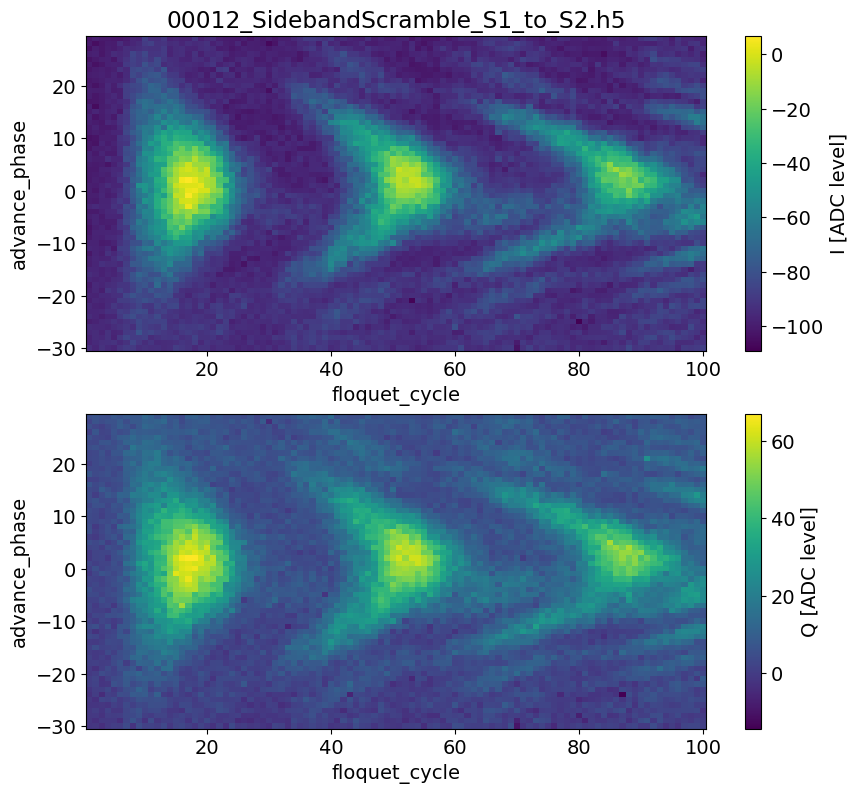

In [ ]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 1, # storage mode number to initialize to n=1 Fock state
    ro_stor = 3, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    init_advance_phases = list(range(-10,10,0.5)), # advance phase of each successive pulse [degrees]
    ro_advance_phases = list(range(-1k,30,1)), # advance phase of each successive pulse [degrees]
    # advance_phase=0,
    swept_params = ['advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    # swap_stors = [1, 2],
    # update_phases = True, 
    echoes = [False, 0], # [on/off, number of echoes]
)

sbs = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = SidebandScrambleProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00013_SidebandScramble_S1_to_S2.h5


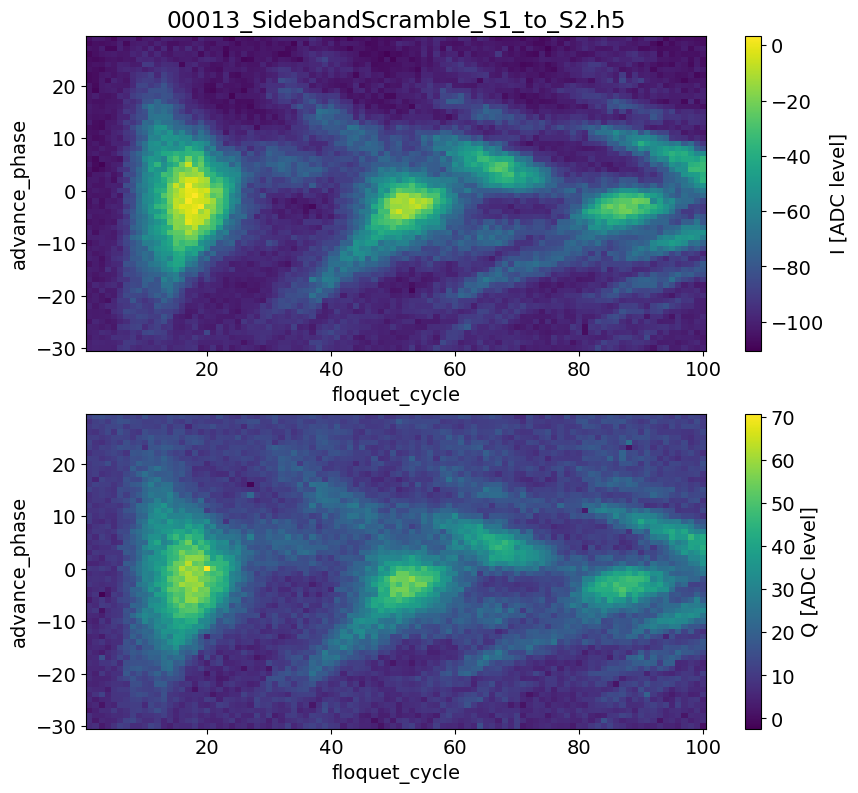

In [46]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 1, # storage mode number to initialize to n=1 Fock state
    ro_stor = 2, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,101)),
    # gain_div = 3,
    # length_div = 2,
    # detune=0,
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    advance_phases = list(range(-30,30,1)), # advance phase of each successive pulse [degrees]
    # advance_phase=0,
    swept_params = ['advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    # swap_stors = [1, 2],
    # update_phases = True, 
    echoes = [False, 0], # [on/off, number of echoes]
)

sbs = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = SidebandScrambleProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

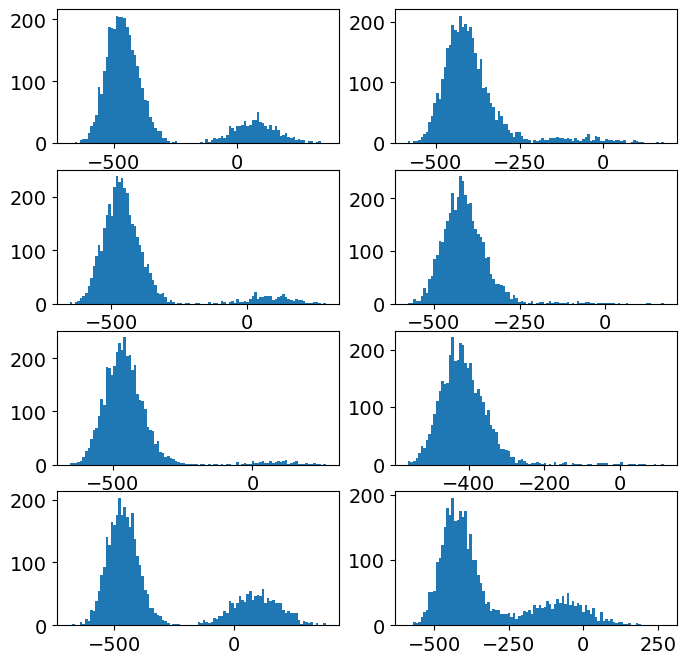

In [98]:
idata = np.array(sbs.data['idata']).ravel()
idata = idata.reshape((len(idata)//4,4))

qdata = np.array(sbs.data['qdata']).ravel()
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

In [263]:
for init_stor in range(3,8):
    # for ro_stor in range(8):
    ro_stor = 0
    for detune in np.linspace(-0.2,0.2,21):
        expt_params = dict(
            expts = 1,
            reps = 1000,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  1/2 name of manipulate cavity
            init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
            ro_stor = ro_stor, # storage mode number that gets read out in the end
            # if 0, this means to read out man instead
            floquet_cycles = list(range(1,101)),
            detune=detune,
            normalize = False,
            active_reset = True,
            man_reset = True, 
            storage_reset = True, 
            advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
            echoes = [False, 0], # [on/off, number of echoes]
        )
        
        sbs = SidebandScrambleExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
            config_file=config_path,
            expt_params = expt_params,
            progress=True)
        
        sbs.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
        sbs.go(analyze=False, display=False, progress=False, save=True)

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00001_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00002_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00003_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00004_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00005_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00006_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00007_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00008_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00009_SidebandS

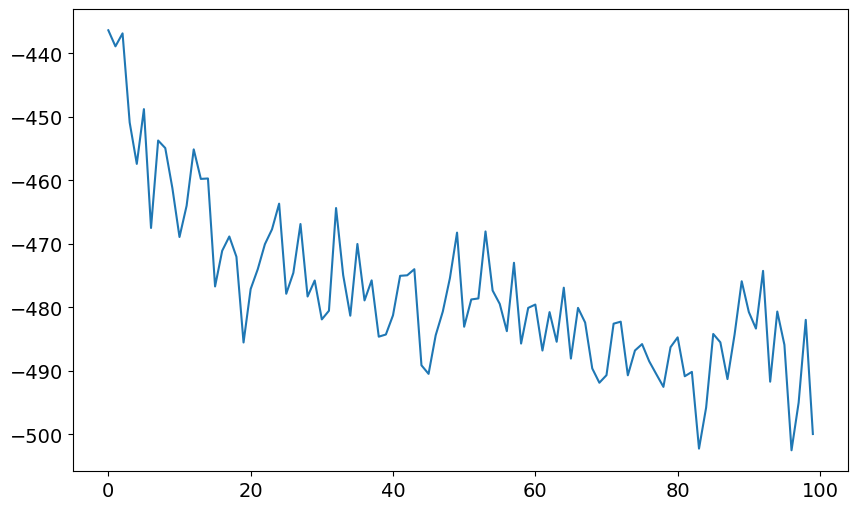

In [259]:
plt.plot(ss[9].data['avgi'])

## Amplitude Rabi

In [11]:
from multimode_expts.experiments.qsim.sideband_amp_rabi import SidebandAmpRabiExperiment

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.floquet_general
imported experiments.qsim.qsim_base
imported experiments.qsim.qsim_experiments
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_ramsey_scramble
imported experiments.qsim.sideband_scramble
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demoluti

In [47]:
for init_stor in range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 500,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detunes=np.linspace(-2,2,101).tolist(),
        gains=list(range(0,20000,100)),
        length=3, # us rabi pulse legnth
        normalize = False,
        active_reset = True,
        man_reset = True, 
        storage_reset = True, 
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sare = SidebandAmpRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandAmpRabi_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    sare.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    sare.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S1.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S2.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S3.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S4.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S5.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S6.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S7.h5


## Find phase offset for ramsey

In [14]:
from multimode_expts.experiments.qsim.sideband_stark import SidebandStarkExperiment, SidebandStarkProgram

In [15]:
# for init_stor in range(1, 8):
for init_stor in range(1, 3):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        detune = 0,
        advance_phases=np.linspace(-90,90,31).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,30,31).tolist(),
        swept_params = ['advance_phase', 'wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        # advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sta = SidebandStarkExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        program=SidebandStarkProgram,
        progress=True)
    
    sta.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sta.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/31 [00:00<?, ?it/s]

pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1', 'pi', 0]
channel name man
pulse param ['M1-S1', 'pi', 0]
channel name storage
pulse_data [[3571.6994214615424 3428.4457610447353 2011.6693654525284
  348.702401768369]
 [3429 2770 8000 3000]
 [0.0 0.0 0.5408883810926033 0.9174265564762912]
 [0 0 0 0]
 [2 2 0 1]
 ['gauss' 'gauss' 'flat_top' 'flat_top']
 [0.035 0.035 0.005 0.005]]
pulse param ['M1', 'pi', 0]
channel name man
pulse_data [[2011.6693654525284]
 [8000]
 [0.5408883810926033]
 [0]
 [0]
 ['flat_top']
 [0.005]]
pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1

  0%|          | 0/31 [00:00<?, ?it/s]

pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1', 'pi', 0]
channel name man
pulse param ['M1-S2', 'pi', 0]
channel name storage
pulse_data [[3571.6994214615424 3428.4457610447353 2011.6693654525284
  520.1370383281906]
 [3429 2770 8000 5000]
 [0.0 0.0 0.5408883810926033 1.084581933496189]
 [0 0 0 0]
 [2 2 0 1]
 ['gauss' 'gauss' 'flat_top' 'flat_top']
 [0.035 0.035 0.005 0.005]]
pulse param ['M1', 'pi', 0]
channel name man
pulse_data [[2011.6693654525284]
 [8000]
 [0.5408883810926033]
 [0]
 [0]
 ['flat_top']
 [0.005]]
pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1

c:\Users\26049\.conda\envs\slab\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


AC Stark freq: 0.199627MHz


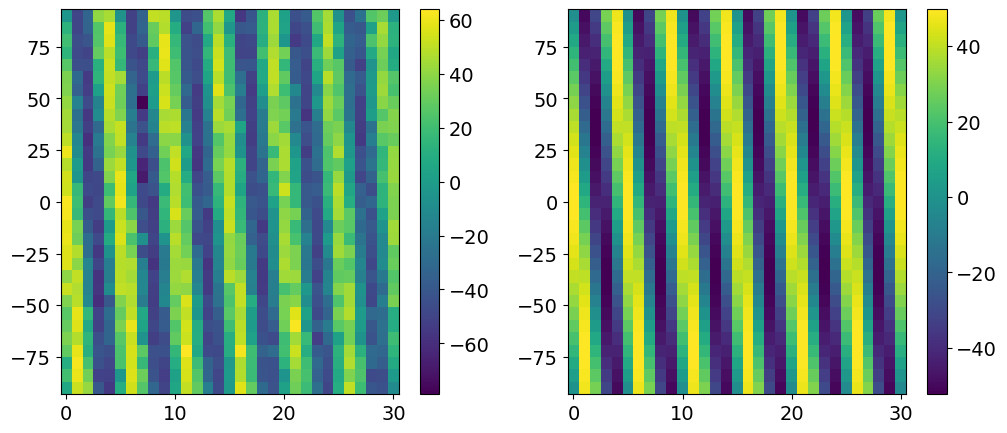

In [17]:
sta.analyze()

In [19]:
for init_stor in [1]: #range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 500,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        detune = 0,
        phases=np.linspace(-90,90,91).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,2,51).tolist(),
        swept_params = ['phase', 'wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = True,
        man_reset = True, 
        storage_reset = True, 
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sta = SidebandStarkExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    sta.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    sta.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/91 [00:00<?, ?it/s]

KeyboardInterrupt: 

### new base class general 2D

In [20]:
from multimode_expts.experiments.qsim.sideband_stark import SidebandStarkProgram
from multimode_expts.experiments.qsim.qsim_base import QsimBaseExperiment

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00002_SidebandStark_S2.h5


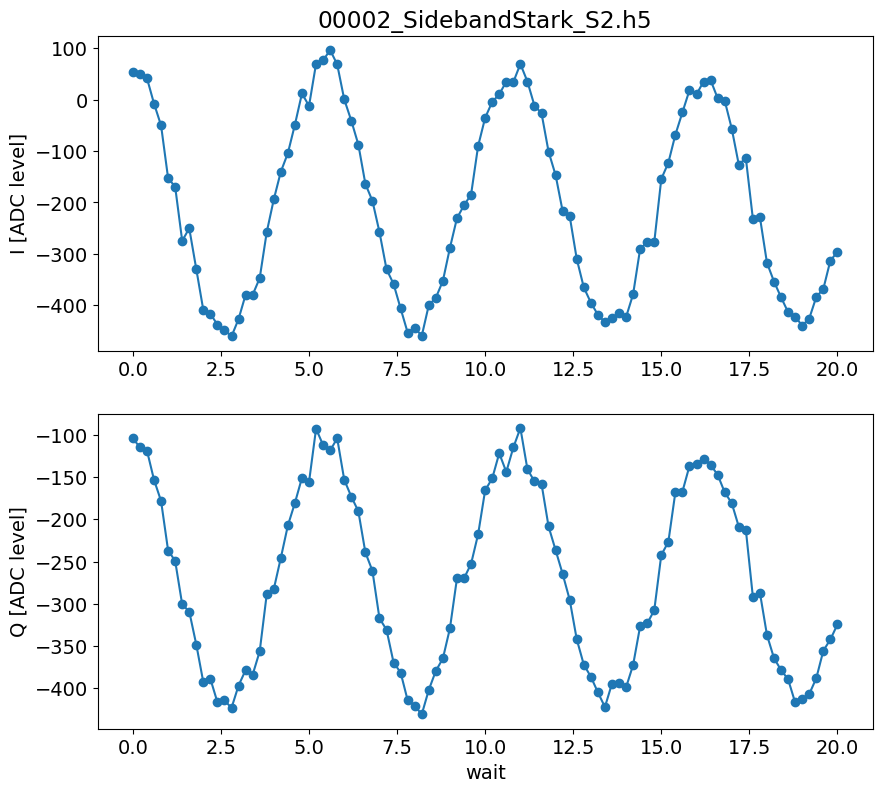

In [106]:
for init_stor in [2]: #range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detune = 0,
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        # advance_phases=np.linspace(-90,90,91).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,20,101).tolist(),
        swept_params = ['wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    qbe = QsimBaseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params=expt_params,
        program=SidebandStarkProgram,
        progress=True)
    
    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.go(analyze=False, display=True, progress=True, save=True)

### T1

In [ ]:
from multimode_expts.experiments.qsim.sideband_scramble import StorageT1Program

  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_StorageT1_S0.h5


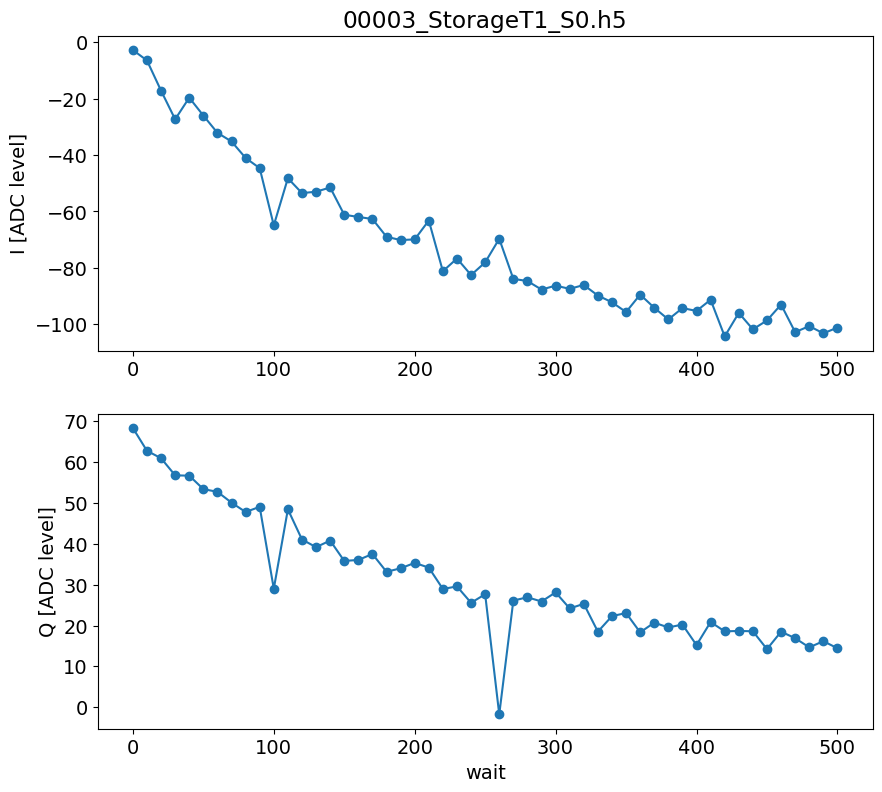

In [53]:
init_stor = 0
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
    ro_stor = init_stor, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    # wait=10, # wait time between two hpi pulses in us
    waits = np.linspace(0,500,51).tolist(),
    swept_params = ['wait'],
    # usage: if you want to sweep cfg.expt.paramName, 
    # include paramName here in this list 
    # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
    # (You want a list instead of numpy array for better yaml export.)
    # Currently handles 1D and 2D sweeps and plots only.
    # For 2D, order is [outer, inner].
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    prepulse = True,
    postpulse = True,
    echoes = [False, 0], # [on/off, number of echoes]
)

qbe = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StorageT1_S{expt_params['init_stor']}",
    config_file=config_path,
    expt_params=expt_params,
    program=StorageT1Program,
    progress=True)

qbe.cfg.device.readout.relax_delay = [5000]  # Wait time between experiments [us]
qbe.go(analyze=False, display=True, progress=True, save=True)

# Kerr engineering

  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00014_KerrQBHeating.h5


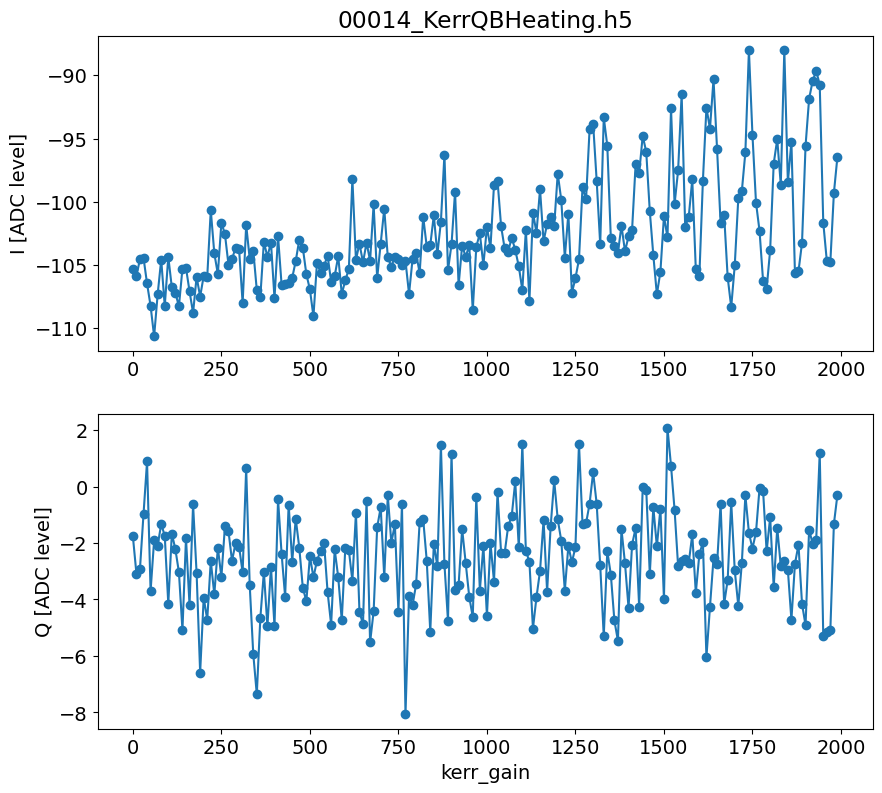

In [ ]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 0, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    echoes = [False, 0], # [on/off, number of echoes]
    # === new class
    # kerr_gain = 1000,
    kerr_detune = -10,
    kerr_length = 10,
    swept_params = ['kerr_gain'],
    # kerr_lengths = np.linspace(0.007,5,21).tolist(),
    kerr_gains = np.arange(0,2000,10).tolist(),
    prepulse = False,
    postpulse = False,
)

qbe = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"KerrQBHeating",
    config_file=config_path,
    expt_params=expt_params,
    program=meas.KerrEngBaseProgram,
    progress=True)

qbe.cfg.device.readout.relax_delay = [2000]  # Wait time between experiments [us]
qbe.go(analyze=False, display=True, progress=True, save=True)

## Cavity Ramsey 

This is to find out $\chi$, $\chi'$, $\Delta$ and $K_c$

In [34]:
def do_cavity_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True, config_thisrun.device.manipulate.f_ge[man_mode_no-1], 10, 
                                config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 0,
                                  4]
        
    #[on/off, freq, gain, sigma (mus), phase, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        prep_e_first=prep_e_first,  # prepare e first
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

In [ ]:
cavity_ramsey = do_cavity_ramsey(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    man_mode_no=1, 
    ramsey_freq=1,
    step = 0.02, 
    expts = 100, 
    reps = 100,
    prep_e_first = False,
    # user_defined_pulse=[True, expts_base_inst.config_thisrun.device.manipulate.f_ge[0], 1500, 
    #                             expts_base_inst.config_thisrun.device.manipulate.displace_sigma[0],
    #                               0, 4])
    user_defined_pulse=[True, config_thisrun.device.manipulate.f_ge[0], 2000, 
                                config_thisrun.device.manipulate.displace_sigma[0],
                                  0, 4])


    #user defined pulse [on/off, freq, gain, sigma (mus), phase, channel] )

100


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00035_CavityRamseyExperiment.h5


No echoes in the data
Attempted to init fitparam 4 to -39.526406277056275, which is out of bounds -8.151926406926407 to 5.25439393939394. Instead init to -1.4487662337662335
Using user defined frequency: 4984.619558610203 MHz
Current pi pulse frequency: 4984.619558610203
Fit frequency from I [MHz]: 0.36424401901754655 +/- 0.0011338325591566745
Suggested new pi pulse frequency from fit I [MHz]:
 	4984.655314591186
 	4985.383802629221
T2 Ramsey from fit I [us]: 68.42134499725387
Fit frequency from Q [MHz]: 0.35470452184700024 +/- 0.011681988196307986
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4984.664854088356
 	4985.37426313205
T2 Ramsey from fit Q [us]: 6.467222310401915


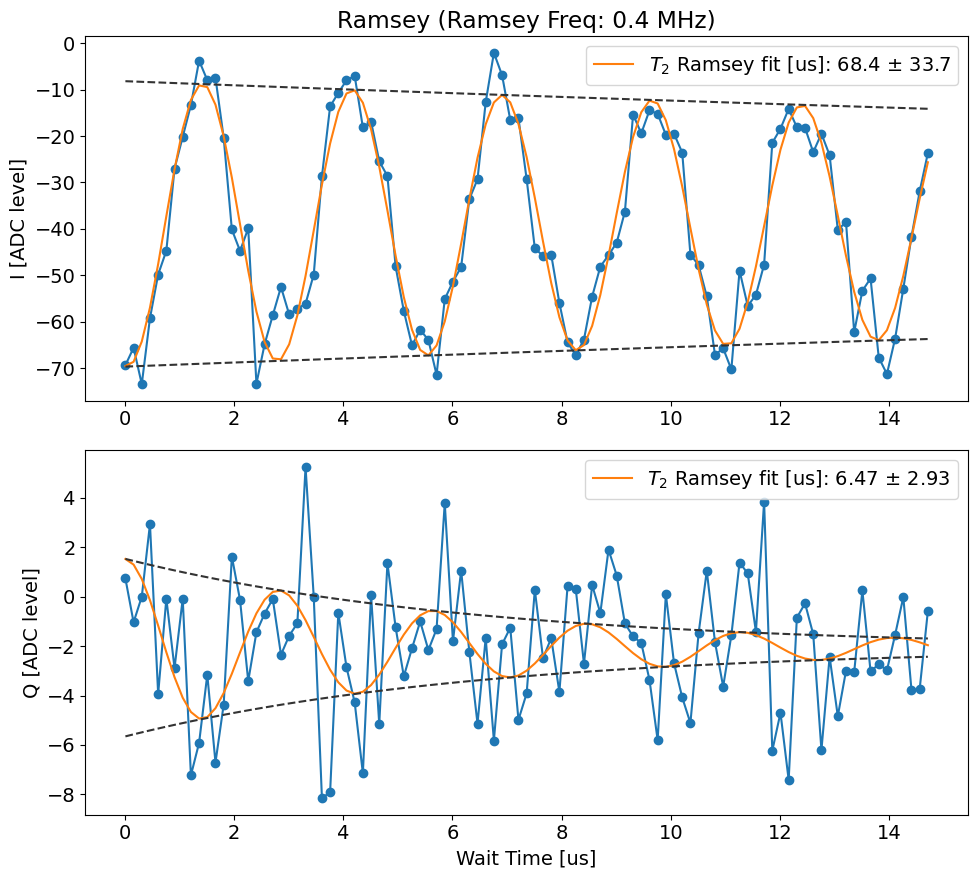

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-07_14-36-00_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-07.md


In [40]:
cavity_ramsey.analyze()
cavity_ramsey.display()

### vs gain

In [25]:
def do_cavity_ramsey_gain_sweep(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    gain_start = 1000,  # start gain
    gain_step = 1000,      # step size for gain
    gain_expts = 5,        # number of experiments for gain
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    relax_delay=2500,      # relax delay
    do_g_and_e=False, # do e-f first
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True,
                              config_thisrun.device.manipulate.f_ge[man_mode_no-1], 
                              1000, 
                              config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 
                              0,
                              4]
    #[on/off, freq, gain, sigma (mus), length, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyGainSweepExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyGainSweepExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        gain_start=gain_start,          # start gain
        gain_step=gain_step,            # step size for gain
        gain_expts=gain_expts,          # number of experiments for gain
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        do_g_and_e=do_g_and_e,  # do e-f first

        qubit_drive_pulse=[True],
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey



In [29]:
gain_start = 1000
gain_stop = 7000
gain_step = 1000
gain_expts = int((gain_stop - gain_start) / gain_step) + 1
print(f'Gain start: {gain_start}, Gain stop: {gain_stop}, Gain step: {gain_step}, Gain expts: {gain_expts}')

Gain start: 1000, Gain stop: 7000, Gain step: 1000, Gain expts: 7


In [41]:
cavity_ramsey_sweep = do_cavity_ramsey_gain_sweep(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    gain_start=gain_start,  # start gain
    gain_step=gain_step,      # step size for gain
    gain_expts=gain_expts,        # number of experiments for gain
    ramsey_freq=0.8,
    step = 0.05, 
    expts = 100, 
    reps = 100,
    do_g_and_e=False,
)

  0%|          | 0/7 [00:00<?, ?it/s]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 14%|█▍        | 1/7 [00:25<02:31, 25.29s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 29%|██▊       | 2/7 [00:50<02:06, 25.29s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 43%|████▎     | 3/7 [01:15<01:41, 25.29s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 57%|█████▋    | 4/7 [01:41<01:15, 25.28s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 71%|███████▏  | 5/7 [02:06<00:50, 25.28s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

 86%|████████▌ | 6/7 [02:31<00:25, 25.29s/it]

{(0, '0'): (0, 0), (0, 'freq'): (0, 22), (0, 'phase'): (0, 23), (0, 'addr'): (0, 24), (0, 'gain'): (0, 25), (0, 'mode'): (0, 26), (0, 't'): (0, 27), (0, 'addr2'): (0, 28), (0, 'gain2'): (0, 29), (0, 'mode2'): (0, 30), (0, 'mode3'): (0, 31), (1, '0'): (1, 0), (1, 'freq'): (1, 12), (1, 'phase'): (1, 13), (1, 'addr'): (1, 14), (1, 'gain'): (1, 15), (1, 'mode'): (1, 16), (1, 't'): (1, 17), (1, 'addr2'): (1, 18), (1, 'gain2'): (1, 19), (1, 'mode2'): (1, 20), (1, 'mode3'): (1, 21), (2, '0'): (1, 0), (2, 'freq'): (1, 22), (2, 'phase'): (1, 23), (2, 'addr'): (1, 24), (2, 'gain'): (1, 25), (2, 'mode'): (1, 26), (2, 't'): (1, 27), (2, 'addr2'): (1, 28), (2, 'gain2'): (1, 29), (2, 'mode2'): (1, 30), (2, 'mode3'): (1, 31), (3, '0'): (2, 0), (3, 'freq'): (2, 12), (3, 'phase'): (2, 13), (3, 'addr'): (2, 14), (3, 'gain'): (2, 15), (3, 'mode'): (2, 16), (3, 't'): (2, 17), (3, 'addr2'): (2, 18), (3, 'gain2'): (2, 19), (3, 'mode2'): (2, 20), (3, 'mode3'): (2, 21), (4, '0'): (2, 0), (4, 'freq'): (2, 22),

100%|██████████| 7/7 [02:56<00:00, 25.29s/it]

Saving D:\experiments\251031_qsim\data\00011_CavityRamseyGainSweepExperiment.h5


C:\_Lib\python\multimode_expts\fit_display_classes.py:494: RuntimeWarning: invalid value encountered in divide
  _pop_norm = (_pop - np.max(_pop)) / (np.min(_pop) - np.max(_pop))


gain_to_alpha 0.0002459735289304684
kwargs {}
Kerr : -14.092 +/- 4.863 kHz
detuning Ground State: -52.443 +/- 7.605 kHz


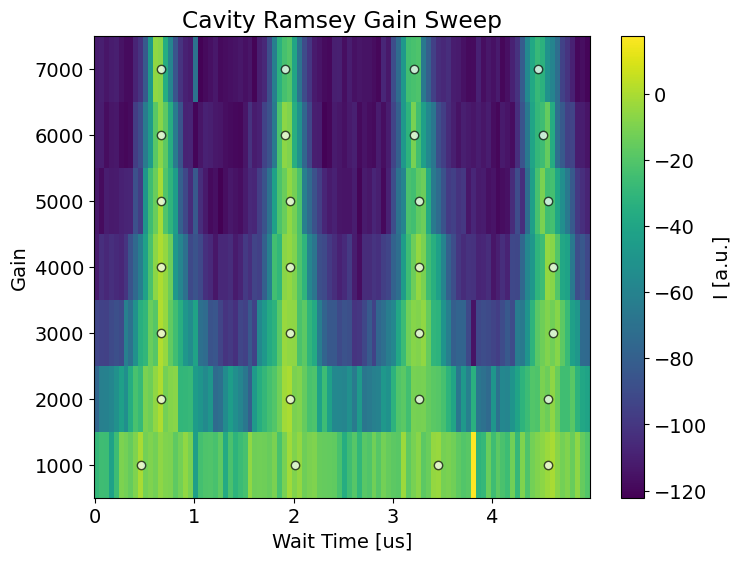

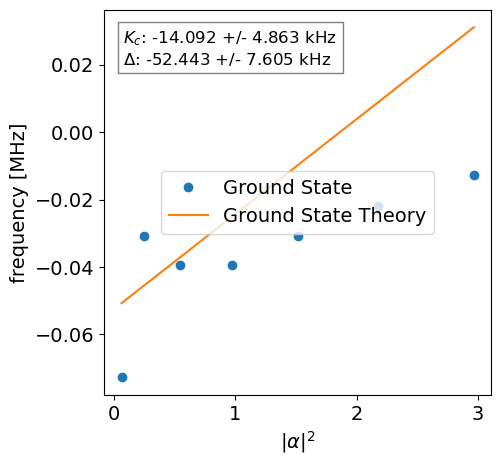

In [42]:
cavity_ramsey_sweep.analyze()
cavity_ramsey_sweep.display()
delta_g = cavity_ramsey_sweep.data['detuning_g']

# config_thisrun.device.manipulate.f_ge[0] -= delta_g
# print(f"Updated f_ge frequency: {config_thisrun.device.manipulate.f_ge[0]} MHz")

## with kerr

In [20]:
from multimode_expts.experiments.qsim.kerr import KerrCavityRamseyProgram

In [21]:
def do_kerr_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.02,            # step size
    expts=100,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    kerr_gain=2000,
    kerr_detune=-10,
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True,
                              config_thisrun.device.manipulate.f_ge[man_mode_no-1], 
                              2000, # will be overridden if expt_params.displace_gain is set! 
                              config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 
                              0,
                              4]
        
    #[on/off, freq, gain, sigma (mus), length, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    expt_params = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse, # post sweep pulse
        prep_e_first=prep_e_first,  # prepare e first
        normalize = False,
        kerr_gain = kerr_gain,
        kerr_detune = kerr_detune,
        # kerr_length = 10,
        # swept_params = ['kerr_length'],
        swept_params = ['displace_gain', 'kerr_length'],
        kerr_lengths = np.linspace(0.007,3,101).tolist(),
        displace_gains = np.arange(2000,8001,1000).tolist(),
        # displace_gain = 5000,
        drive_coupler=True,
        ds_thisrun = ds_storage,
    )

    cavity_ramsey = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"KerrRamseyExperiment",
    config_file=config_path,
    expt_params=expt_params,
    program=KerrCavityRamseyProgram,
    progress=True)

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = expt_params

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey


In [22]:
kerr_ramsey = do_kerr_ramsey(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    ramsey_freq=1,
    kerr_gain=0,
    kerr_detune=-30,
    # step = 0.04, 
    # expts = 150, 
    reps = 100,
    prep_e_first=False,
    # active_reset=True,
    # man_reset=True,
    # relax_delay=300,
)

  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00362_KerrRamseyExperiment.h5


In [35]:
for kerr_detune in [-30,-20,-10,-5,0,5,10,20,30]:
    print(f'detune {kerr_detune}')
    for kerr_gain in range(200,2901,300):
        # print(f"Running Kerr Ramsey with kerr_gain = {kerr_gain}")
        kerr_ramsey = do_kerr_ramsey(
            config_thisrun=config_thisrun,
            expt_path=expt_path,
            config_path=config_file,
            ramsey_freq=1.5,
            kerr_gain=kerr_gain,
            kerr_detune=kerr_detune,
            # step = 0.04, 
            # expts = 150, 
            reps = 100,
            prep_e_first=False,
            # active_reset=True,
            # man_reset=True,
            # relax_delay=300,
        )

detune -30


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00272_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00273_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00274_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00275_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00276_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00277_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00278_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00279_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00280_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00281_KerrRamseyExperiment.h5
detune -20


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00282_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00283_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00284_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00285_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00286_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00287_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00288_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00289_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00290_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00291_KerrRamseyExperiment.h5
detune -10


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00292_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00293_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00294_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00295_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00296_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00297_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00298_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00299_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00300_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00301_KerrRamseyExperiment.h5
detune -5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00302_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00303_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00304_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00305_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00306_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00307_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00308_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00309_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00310_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00311_KerrRamseyExperiment.h5
detune 0


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00312_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00313_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00314_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00315_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00316_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00317_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00318_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00319_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00320_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00321_KerrRamseyExperiment.h5
detune 5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00322_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00323_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00324_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00325_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00326_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00327_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00328_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00329_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00330_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00331_KerrRamseyExperiment.h5
detune 10


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00332_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00333_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00334_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00335_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00336_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00337_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00338_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00339_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00340_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00341_KerrRamseyExperiment.h5
detune 20


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00342_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00343_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00344_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00345_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00346_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00347_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00348_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00349_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00350_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00351_KerrRamseyExperiment.h5
detune 30


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00352_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00353_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00354_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00355_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00356_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00357_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00358_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00359_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00360_KerrRamseyExperiment.h5


  0%|          | 0/7 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00361_KerrRamseyExperiment.h5


In [36]:
def get_dump_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-D' + str(dump_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    pi_len = ds_thisrun.get_pi(stor_name)
    h_pi_len = ds_thisrun.get_h_pi(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    from experiments.MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    prepulse_overwrite = [['multiphoton', 'g0-e0', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0],
                            ['multiphoton', 'f0-g1', 'pi', 0]
                        ]
    postpulse_overwrite = [ ['multiphoton', 'f0-g1', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0]]
    prepulse = mm_base_dummy.get_prepulse_creator(prepulse_overwrite).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(postpulse_overwrite).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, 
                         ds_thisrun, 
                         expt_path, 
                         config_path, 
                         man_mode_no = 1, 
                         dump_no = 1,
                         flux_gain = 5000,
                         flux_length = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_dump_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, dump_no)

    freq_start = 650 #2350 
    freq_stop = 950 #2400
    bw = freq_stop - freq_start
    expts = 600
    step = bw/expts

    flux_spec.cfg.expt = dict(
        # start=freq - 100,  # Start RF frequency [MHz]
        start=freq_start,  # Start RF frequency [MHz]
        step=step,  # Step size [MHz]
        expts=expts,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1, flux_gain, flux_length],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=True,
        man_reset=False,
        storage_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit'][2]}")


In [37]:
spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, 
                            man_mode_no=1, dump_no=1,
                            flux_gain=200, flux_length=10)
spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, 
                            man_mode_no=1, dump_no=1,
                            flux_gain=100, flux_length=10)
spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, 
                            man_mode_no=1, dump_no=1,
                            flux_gain=2000, flux_length=10)
# analyze_and_display_stor_spectroscopy(spec)
# update_dump_spectroscopy(spec, ds_thisrun, 1, 1)
spec.analyze(fit=True)
spec.display()

IndexError: index 0 is out of bounds for axis 0 with size 0

## Qubit rabi

In [20]:
from multimode_expts.experiments.single_qubit.amplitude_rabi import AmplitudeRabiExperiment, AmplitudeRabiChevronExperiment
from multimode_expts.experiments.single_qubit.length_rabi import LengthRabiExperiment

  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00003_LengthRabiExperiment.h5
Decay from avgi [us] 6.2438527410153455
Pi length from avgi data [us]: 0.031232802297960428
	Pi/2 length from avgi data [us]: 0.015616401148980214

Decay from avgq [us] 2.236423934894977
Pi length from avgq data [us]: 0.030617603252438664
Pi/2 length from avgq data [us]: 0.015308801626219332


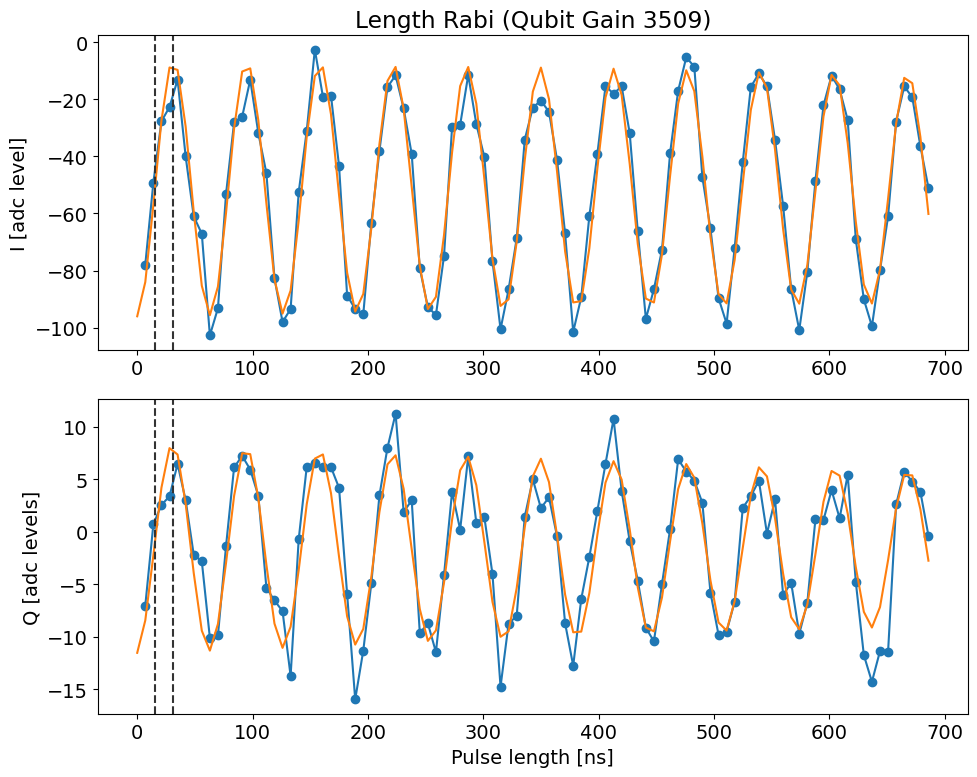

In [21]:
rabi = LengthRabiExperiment(
        soccfg=soc, 
        path=expt_path, 
        prefix='LengthRabiExperiment', 
        config_file=config_path
    )

rabi.cfg = AttrDict(deepcopy(config_thisrun))
rabi.cfg.expt = dict(
    start=0,                    # start delay
    step=0.007,                      # step size
    expts=100,                    # number of experiments
    reps=100,                      # repetitions
    rounds=1,                  # rounds
    qubits=[0],                  # qubits
    checkEF=False,                # check EF
    checkZZ=False,               # check ZZ
    pulse_type='const',        # pulse type
    repeat_time = 1,
    pre_pulse=False,       # pre pulse
    post_pulse=False,            # post pulse
)

rabi.cfg.device.readout.relax_delay = [500]
rabi.go(analyze=True, display=True, progress=True, save=True)

  0%|          | 0/21 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250812_qsim\data\00002_AmplitudeRabiChevronExperiment.h5


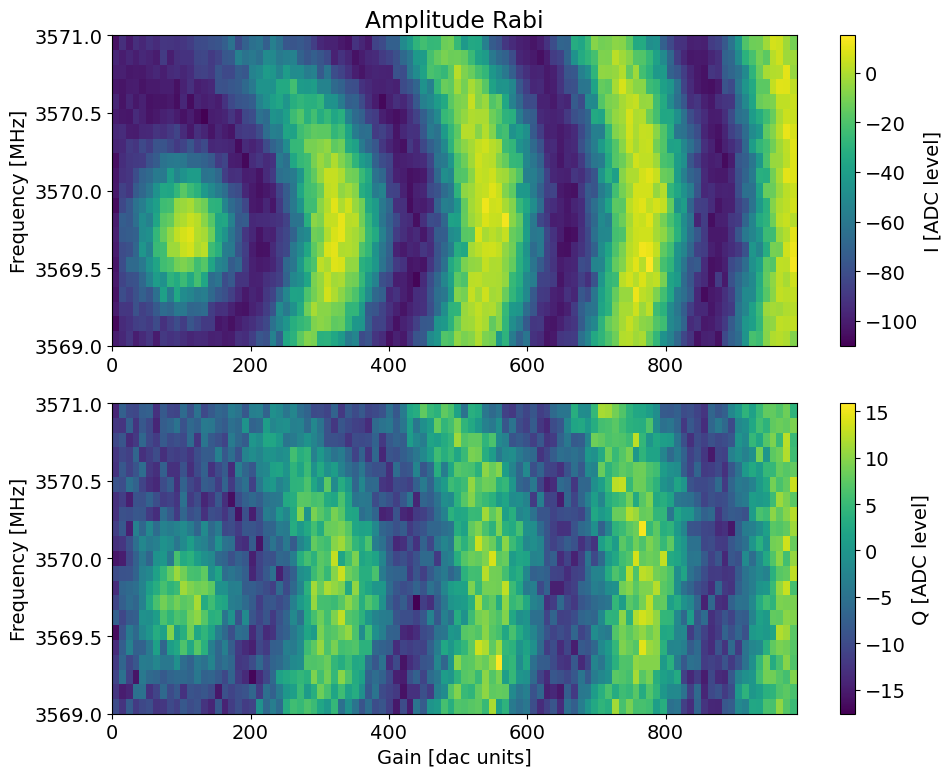

In [37]:
rabi = AmplitudeRabiChevronExperiment(
        soccfg=soc, 
        path=expt_path, 
        prefix='AmplitudeRabiChevronExperiment', 
        config_file=config_path
    )

rabi.cfg = AttrDict(deepcopy(config_thisrun))
rabi.cfg.expt = dict(
    start_f=3569,                # start frequency
    step_f=0.1,                 # f step size
    expts_f=21,                 # number of experiments
    start_gain=0,                    # start delay
    step_gain=10,                      # step size
    expts_gain=100,                    # number of experiments
    reps=100,                      # repetitions
    rounds=1,                  # rounds
    flat_length=0,
    sigma_test=1,
    user_defined_freq=[False,0],  # [on/off, freq]
    qubits=[0],                  # qubits
    checkEF=False,                # check EF
    checkZZ=False,                # check ZZ
    pulse_type='const',        # pulse type
    prepulse=False,       # pre pulse
    postpulse=False,            # post pulse
    pulse_ge_init=False,
    pulse_ge_after=False,
)

rabi.cfg.device.readout.relax_delay = [1500]
rabi.go(analyze=True, display=True, progress=True, save=True)

# Ramp current

In [20]:
# coupler
dcflux = YokogawaGS200(address="192.168.137.148")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.5e-3, sweeprate=0.0001)

In [ ]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.000, sweeprate=0.002)

In [36]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.ramp_current(-0.00454, sweeprate=0.002)

In [20]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.ramp_current(0, sweeprate=0.002)

In [20]:
# coupler
dcflux = YokogawaGS200(address="192.168.137.148")
dcflux.ramp_current(0e-3, sweeprate=1e-4)

## Manipulate parity spectroscopy


In [23]:
def do_parity_freq_experiment(
    start=4960,
    stop=5020,
    step=0.60,
    reps=100,
    rounds=1,
    qubit=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=20,
    manipulate_no=1,
    displace=(True, 0.1, 1000),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500
):
    """
    Run the Parity Frequency Experiment with configurable parameters.
    """
    
    expt_cfg = {
        'start': start,
        'stop': stop,
        'step': step,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubit,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'span': span,
        'manipulate': manipulate_no,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }
    # Example usage of relax_delay in experiment config:
    parity_freq_exp = meas.single_qubit.parity_freq.ParityFreqExperiment(
        soccfg=soc, path=expt_path, 
        prefix='ParityFreqExperiment', config_file=config_file
    )
    parity_freq_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_freq_exp.cfg.expt = expt_cfg
    parity_freq_exp.cfg.device.readout.relax_delay = [relax_delay]
    parity_freq_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_freq_exp


In [24]:
parity_freq_exp = do_parity_freq_experiment()

  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00095_ParityFreqExperiment.h5


Found peak in amps at [MHz] 4979.615462461978, HWHM 1.5240490397392101
Found peak in I at [MHz] 4979.549216957419, HWHM 2.2344682216010305
Found peak in Q at [MHz] 4983.343914390137, HWHM 13.55073301977434


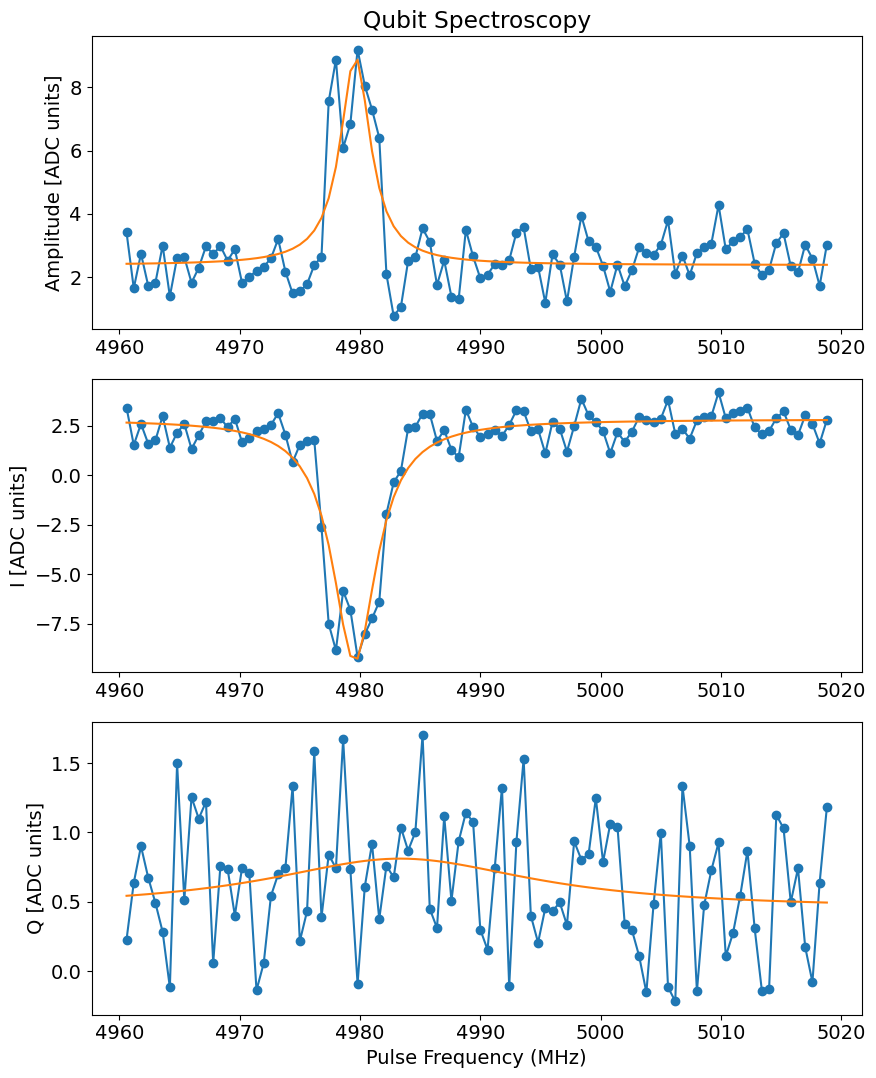

In [28]:
from fitting.fit_display_classes import Spectroscopy
spec = Spectroscopy(parity_freq_exp.data, config=parity_freq_exp.cfg)
spec.analyze()
spec.display()

In [23]:
config_thisrun.device.manipulate.f_ge[0] = spec.data['fit_avgi'][2]

## Gain to alpha

In [29]:
def do_parity_gain_experiment(
    config_thisrun,
    expt_path,
    config_path,
    start=0,
    step=100,
    expts=40,
    reps=250,
    rounds=1,
    qubit=0,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=1000,
    singleshot_active_reset=False,
    singleshot_man_reset=True,
    singleshot_storage_reset=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    span=1000,
    prep_e=False,
    manipulate=1,
    displace=(True, 0.05), # [enable, sigma] (gaussian length is 4sigma)
    const_pulse=(False, 1), # [enable, length]
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500, 
    pulse_correction=False
):
    """
    Run the Parity Gain Experiment with configurable parameters.
    """
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubit': qubit,
        'qubits': qubits,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'singleshot_active_reset': singleshot_active_reset,
        'singleshot_man_reset': singleshot_man_reset,
        'singleshot_storage_reset': singleshot_storage_reset,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'span': span,
        'prep_e': prep_e,
        'manipulate': manipulate,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pulse_correction': pulse_correction
    }
    parity_gain_exp = meas.single_qubit.parity_gain.ParityGainExperiment(
        soccfg=soc, path=expt_path, prefix='ParityGainExperiment', config_file=config_path
    )
    parity_gain_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_gain_exp.cfg.expt = expt_cfg
    parity_gain_exp.cfg.device.readout.relax_delay = [relax_delay]
    
    parity_gain_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_gain_exp


4979.50248109926
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

4979.50248109926
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00331_ParityGainExperiment.h5
Gain to Alpha Conversion Factor: 0.0006606564470537082


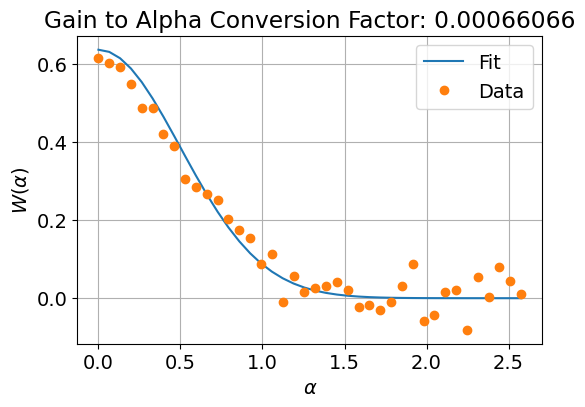

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-21_14-06-49_Gain_to_Alpha_Conversion_Factor_0.00066066.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-21.md
alpha = 1 requires gain of : 1513.64601747


{'xpts': array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
        3300, 3400, 3500, 3600, 3700, 3800, 3900,    0,  100,  200,  300,
         400,  500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400,
        1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500,
        2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600,
        3700, 3800, 3900]),
 'avgi': array([-19.67612554, -19.27963203, -19.61218615, -18.78654762,
        -17.2320671 , -16.32030303, -16.19962121, -16.01557359,
        -13.90439394, -13.85480519, -13.16258658, -13.53778139,
        -12.42669913, -11.36353896, -11.75844156, -10.27902597,
         -9.75880952,  -8.60227273,  -9.52790043,  -8.37634199,
         -9.70314935,  -9.29048701,  -9.54634199,  -7.76404762,
         -6.67811688,  -9.18925325,  -7.50772727,  -8.

In [30]:
parity_gain_expt = do_parity_gain_experiment(
    config_thisrun=config_thisrun,
    expt_path=expt_path,
    config_path=config_file,
    pulse_correction=True,
    reps=200,
)

parity_gain_expt.analyze()

In [26]:
#update device
gain_to_alpha = parity_gain_expt.data['gain_to_alpha']
print(f'Gain to alpha: {gain_to_alpha}')
config_thisrun.device.manipulate.gain_to_alpha[0] = gain_to_alpha

Gain to alpha: 0.00026453214215320896


### monitoring

Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00228_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026365685319433124
alpha = 1 requires gain of : 3792.80867493
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00229_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002451014481497251
alpha = 1 requires gain of : 4079.94325431
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00230_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002530172611243222
alpha = 1 requires gain of : 3952.29952121
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00231_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002573498371861702
alpha = 1 requires gain of : 3885.76115273
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00232_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002507914340076773
alpha = 1 requires gain of : 3987.37701691
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00233_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002595156748112894
alpha = 1 requires gain of : 3853.33179095
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00234_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025722770563805413
alpha = 1 requires gain of : 3887.60610961
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00235_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002486333068686133
alpha = 1 requires gain of : 4021.98728961
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00236_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024314762692875184
alpha = 1 requires gain of : 4112.72778037
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00237_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002476416699132558
alpha = 1 requires gain of : 4038.09262129
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00238_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024391739563501652
alpha = 1 requires gain of : 4099.74859479
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00239_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026330412675771474
alpha = 1 requires gain of : 3797.88958234
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00240_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025144816709965224
alpha = 1 requires gain of : 3976.96277342
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00241_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024580419693645626
alpha = 1 requires gain of : 4068.27878638
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00242_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002586429857247679
alpha = 1 requires gain of : 3866.33334439
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00243_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024816249407045806
alpha = 1 requires gain of : 4029.61778630
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00244_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024126394534227473
alpha = 1 requires gain of : 4144.83812980
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00245_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002572327710270661
alpha = 1 requires gain of : 3887.52955546
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00246_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002626375860256172
alpha = 1 requires gain of : 3807.52814223
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00247_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00023598038813486908
alpha = 1 requires gain of : 4237.64028826
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00248_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002490609162189629
alpha = 1 requires gain of : 4015.08199352
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00249_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024906714481459744
alpha = 1 requires gain of : 4014.98158557
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00250_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002649615453324124
alpha = 1 requires gain of : 3774.13257741
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00251_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002519337604669183
alpha = 1 requires gain of : 3969.29731905
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00252_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024747491935698775
alpha = 1 requires gain of : 4040.81352001
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00253_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002606288325304501
alpha = 1 requires gain of : 3836.87403382
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00254_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002488583161988746
alpha = 1 requires gain of : 4018.35074381
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00255_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024826432411174747
alpha = 1 requires gain of : 4027.96496669
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00256_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002450498525768496
alpha = 1 requires gain of : 4080.80229180
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00257_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002566933059655394
alpha = 1 requires gain of : 3895.69956349
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00258_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.000253512853785232
alpha = 1 requires gain of : 3944.57316491
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00259_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002595155034724477
alpha = 1 requires gain of : 3853.33433502
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00260_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.000245755077366849
alpha = 1 requires gain of : 4069.09192158
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00261_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002631301176088885
alpha = 1 requires gain of : 3800.40114407
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00262_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002545491808734575
alpha = 1 requires gain of : 3928.51391848
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00263_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002595105875388502
alpha = 1 requires gain of : 3853.40732910
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00264_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002623776358398284
alpha = 1 requires gain of : 3811.30044411
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00265_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025723221981019476
alpha = 1 requires gain of : 3887.53788595
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00266_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00023829754455974357
alpha = 1 requires gain of : 4196.43434366
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00267_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002531773055593601
alpha = 1 requires gain of : 3949.80110003
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00268_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024763257920545163
alpha = 1 requires gain of : 4038.24086156
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00269_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024885595716331164
alpha = 1 requires gain of : 4018.38883585
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00270_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002517878930290656
alpha = 1 requires gain of : 3971.59683879
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00271_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024501342545987196
alpha = 1 requires gain of : 4081.40900085
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00272_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025549138291831045
alpha = 1 requires gain of : 3914.02633066
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00273_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024993461869218705
alpha = 1 requires gain of : 4001.04637458
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00274_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002457993427686567
alpha = 1 requires gain of : 4068.35912878
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00275_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002613167809507376
alpha = 1 requires gain of : 3826.77299315
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00276_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025804216887231874
alpha = 1 requires gain of : 3875.33558709
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00277_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002603572056234406
alpha = 1 requires gain of : 3840.87698900
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00278_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002517889479507536
alpha = 1 requires gain of : 3971.58019897
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00279_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002450541328050775
alpha = 1 requires gain of : 4080.73101463
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00280_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002631273754086596
alpha = 1 requires gain of : 3800.44075021
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00281_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002511707119875751
alpha = 1 requires gain of : 3981.35591561
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00282_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024381927587200966
alpha = 1 requires gain of : 4101.39844942
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00283_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002612758099517713
alpha = 1 requires gain of : 3827.37307439
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00284_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025666407611901927
alpha = 1 requires gain of : 3896.14322004
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00285_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002535141295923207
alpha = 1 requires gain of : 3944.55331388
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00286_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002474257987119814
alpha = 1 requires gain of : 4041.61572967
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00287_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002504427511707361
alpha = 1 requires gain of : 3992.92850492
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00288_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025266529575512705
alpha = 1 requires gain of : 3957.80511531
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00289_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026718984493774475
alpha = 1 requires gain of : 3742.65721152
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00290_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002529038481644684
alpha = 1 requires gain of : 3954.07190226
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00291_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002514461985416554
alpha = 1 requires gain of : 3976.99390884
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00292_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024974105630986096
alpha = 1 requires gain of : 4004.14739481
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00293_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025050603531397923
alpha = 1 requires gain of : 3991.91979046
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00294_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002438379733486951
alpha = 1 requires gain of : 4101.08395451
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00295_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002469798604620594
alpha = 1 requires gain of : 4048.91313052
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00296_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024510921113173896
alpha = 1 requires gain of : 4079.81403629
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00297_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024953576648808297
alpha = 1 requires gain of : 4007.44155467
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00298_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024371304456412325
alpha = 1 requires gain of : 4103.18619501
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00299_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002488837247091169
alpha = 1 requires gain of : 4017.94051085
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00300_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002609748984797691
alpha = 1 requires gain of : 3831.78614428
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00301_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026901763505753805
alpha = 1 requires gain of : 3717.22842551
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00302_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024815551762711273
alpha = 1 requires gain of : 4029.73107172
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00303_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024816302386944193
alpha = 1 requires gain of : 4029.60918354
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00304_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002431086713694711
alpha = 1 requires gain of : 4113.38680092
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00305_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024570750031592943
alpha = 1 requires gain of : 4069.87983156
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00306_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026526127726883716
alpha = 1 requires gain of : 3769.86799693
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00307_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024645392902359286
alpha = 1 requires gain of : 4057.55349067
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00308_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026130809226449533
alpha = 1 requires gain of : 3826.90023617
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00309_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002486315755564302
alpha = 1 requires gain of : 4022.01529617
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00310_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025722853638113495
alpha = 1 requires gain of : 3887.59355423
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00311_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025454626687297166
alpha = 1 requires gain of : 3928.55889141
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00312_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002526655688536352
alpha = 1 requires gain of : 3957.80083744
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00313_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.000253392885945428
alpha = 1 requires gain of : 3946.44070716
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00314_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002530138281383116
alpha = 1 requires gain of : 3952.35314749
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00315_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002524158568583021
alpha = 1 requires gain of : 3961.71624258
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00316_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002687293655916602
alpha = 1 requires gain of : 3721.21594452
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00317_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024517483936255594
alpha = 1 requires gain of : 4078.72195450
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00318_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002675046575476996
alpha = 1 requires gain of : 3738.25266882
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00319_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002590589176662893
alpha = 1 requires gain of : 3860.12575444
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00320_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00025028017830490824
alpha = 1 requires gain of : 3995.52216549
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00321_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002419796575820243
alpha = 1 requires gain of : 4132.57878779
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00322_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026063085690658673
alpha = 1 requires gain of : 3836.84423199
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00323_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00024232036725030354
alpha = 1 requires gain of : 4126.76825868
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00324_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002514412938187236
alpha = 1 requires gain of : 3977.07148580
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00325_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00027496666720841007
alpha = 1 requires gain of : 3636.80445398
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00326_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002491632312560154
alpha = 1 requires gain of : 4013.43326204
Pulse correction is applied
4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

4984.619558610203
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 200


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00327_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00026881234012999963
alpha = 1 requires gain of : 3720.06731356


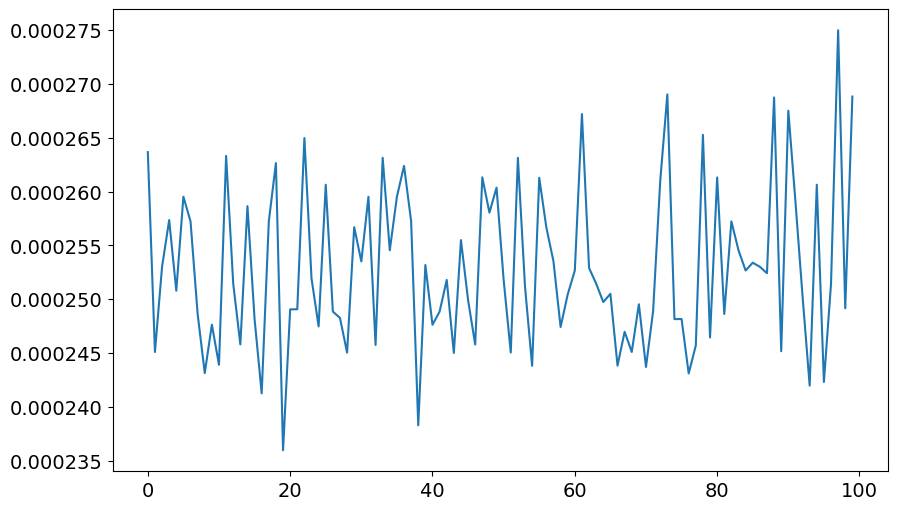

In [70]:
from time import sleep

all_gtas = []

for i in range(100):
    parity_gain_expt = do_parity_gain_experiment(
        config_thisrun=config_thisrun,
        expt_path=expt_path,
        config_path=config_file,
        pulse_correction=True,
        reps=200,
    )

    parity_gain_expt.analyze(plot=False)
    gain_to_alpha = parity_gain_expt.data['gain_to_alpha']
    all_gtas.append(gain_to_alpha)
    sleep(300)

plt.plot(all_gtas)

## nonlinearity vs flux bias

In [24]:
np.linspace(0.75e-3, 0.1e-3, 66)[:40]

array([0.00075, 0.00074, 0.00073, 0.00072, 0.00071, 0.0007 , 0.00069,
       0.00068, 0.00067, 0.00066, 0.00065, 0.00064, 0.00063, 0.00062,
       0.00061, 0.0006 , 0.00059, 0.00058, 0.00057, 0.00056, 0.00055,
       0.00054, 0.00053, 0.00052, 0.00051, 0.0005 , 0.00049, 0.00048,
       0.00047, 0.00046, 0.00045, 0.00044, 0.00043, 0.00042, 0.00041,
       0.0004 , 0.00039, 0.00038, 0.00037, 0.00036])

  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00075_ParityFreqExperiment.h5
Pulse correction is applied
5005.112257677008
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

5005.112257677008
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00002_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002949515473738482


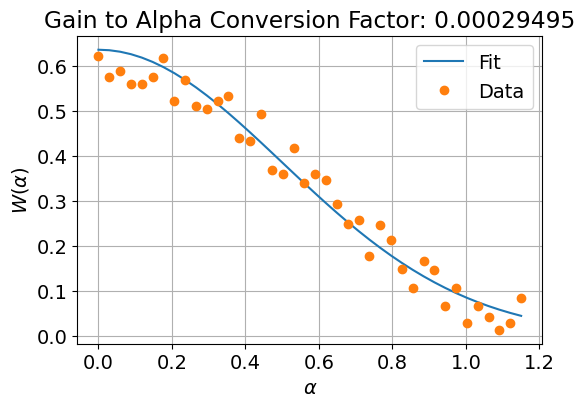

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-04_23-36-42_Gain_to_Alpha_Conversion_Factor_0.00029495.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-04.md
alpha = 1 requires gain of : 3390.38736668
Gain to alpha: 0.0002949515473738482


  0%|          | 0/16 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00123_KerrRamseyExperiment.h5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00076_ParityFreqExperiment.h5
Pulse correction is applied
5003.048330496247
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

5003.048330496247
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00003_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0003011569859539486


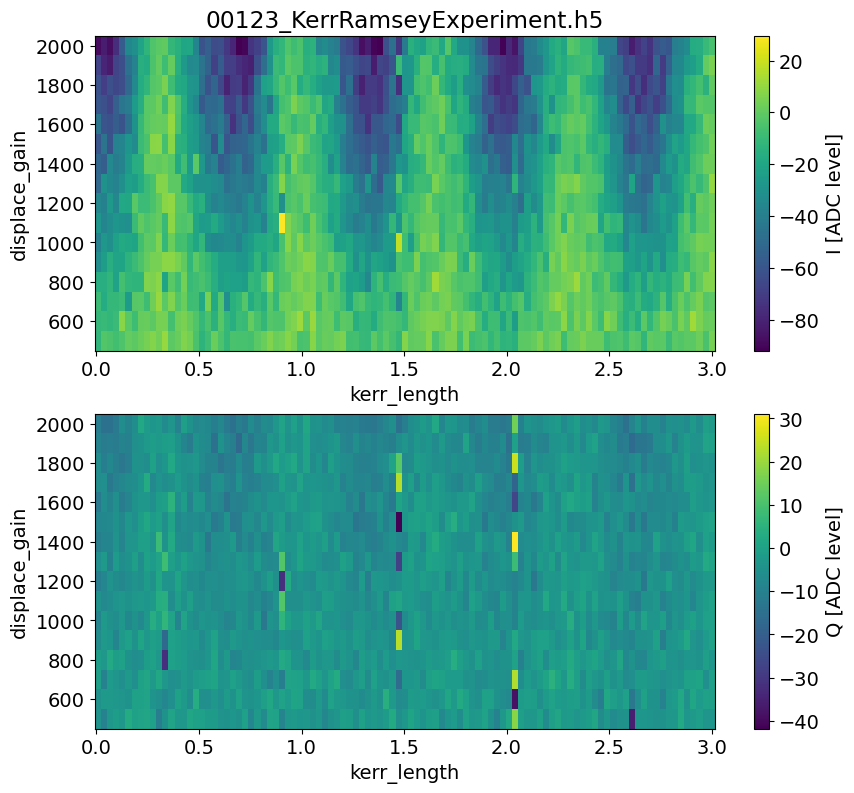

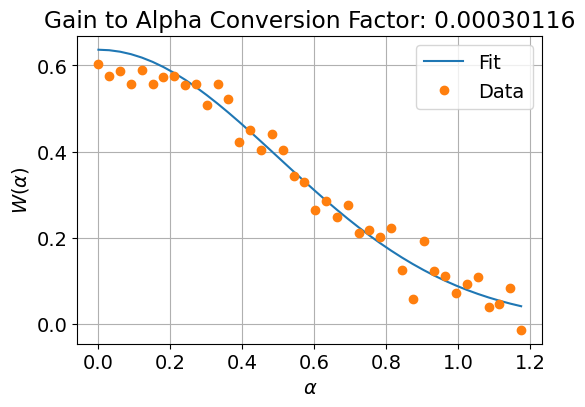

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-04_23-50-48_Gain_to_Alpha_Conversion_Factor_0.00030116.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-04.md
alpha = 1 requires gain of : 3320.52732176
Gain to alpha: 0.0003011569859539486


  0%|          | 0/16 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00124_KerrRamseyExperiment.h5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00077_ParityFreqExperiment.h5
Pulse correction is applied
5000.478613968114
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

5000.478613968114
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00004_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002814281053857867


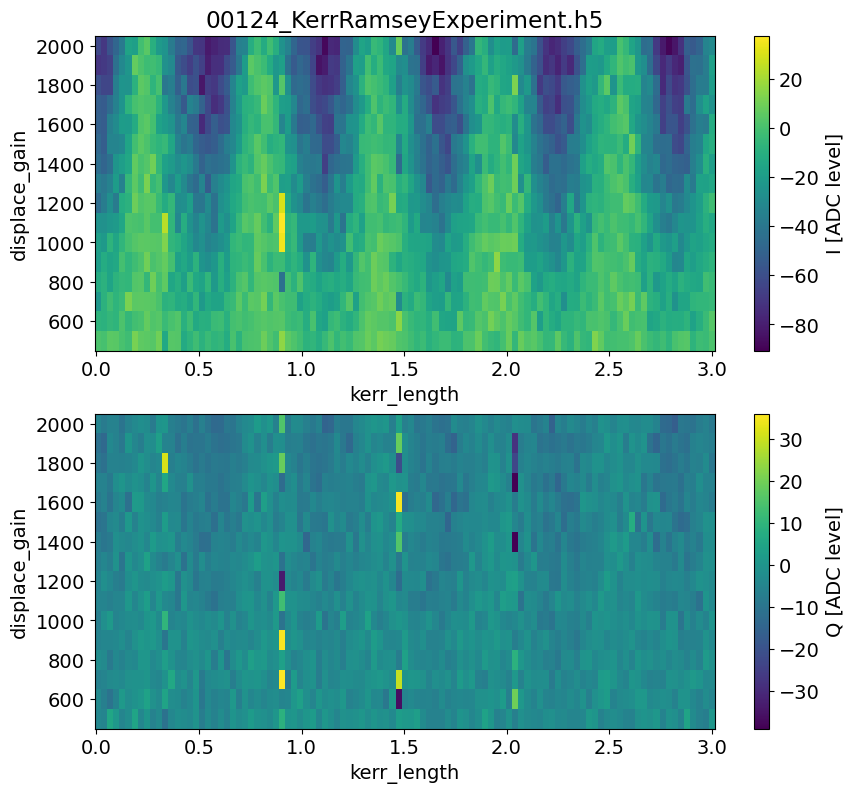

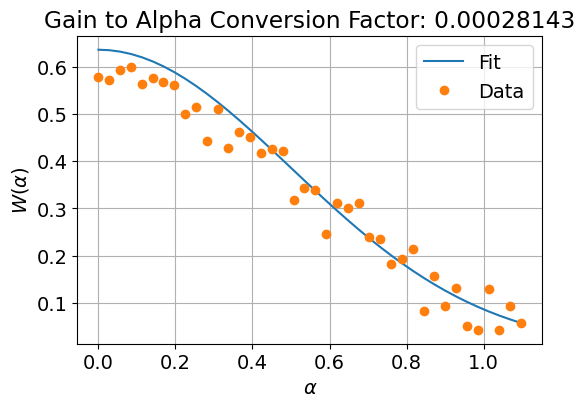

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-05_00-05-17_Gain_to_Alpha_Conversion_Factor_0.00028143.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-05.md
alpha = 1 requires gain of : 3553.30537662
Gain to alpha: 0.0002814281053857867


  0%|          | 0/16 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00125_KerrRamseyExperiment.h5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00078_ParityFreqExperiment.h5
Pulse correction is applied
4998.478183853273
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

4998.478183853273
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00005_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.000272831170696058


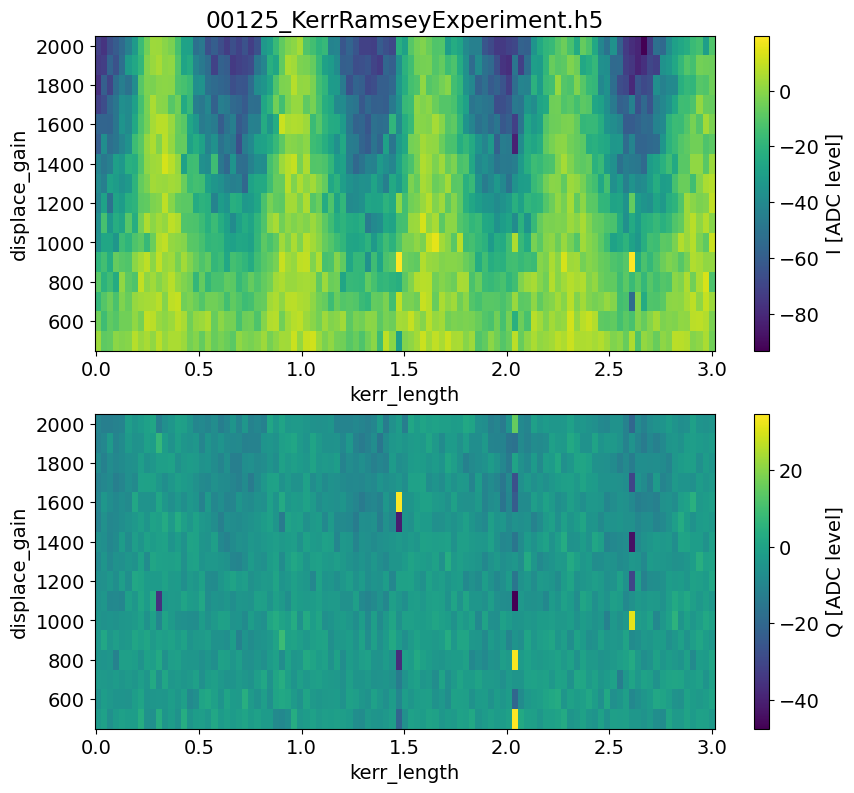

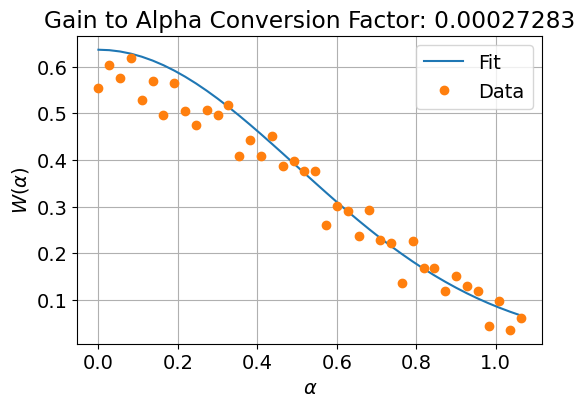

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-05_00-19-48_Gain_to_Alpha_Conversion_Factor_0.00027283.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-05.md
alpha = 1 requires gain of : 3665.27034814
Gain to alpha: 0.000272831170696058


  0%|          | 0/16 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00126_KerrRamseyExperiment.h5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00079_ParityFreqExperiment.h5
Pulse correction is applied
4995.866772755788
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

4995.866772755788
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00006_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.0002859405023926809


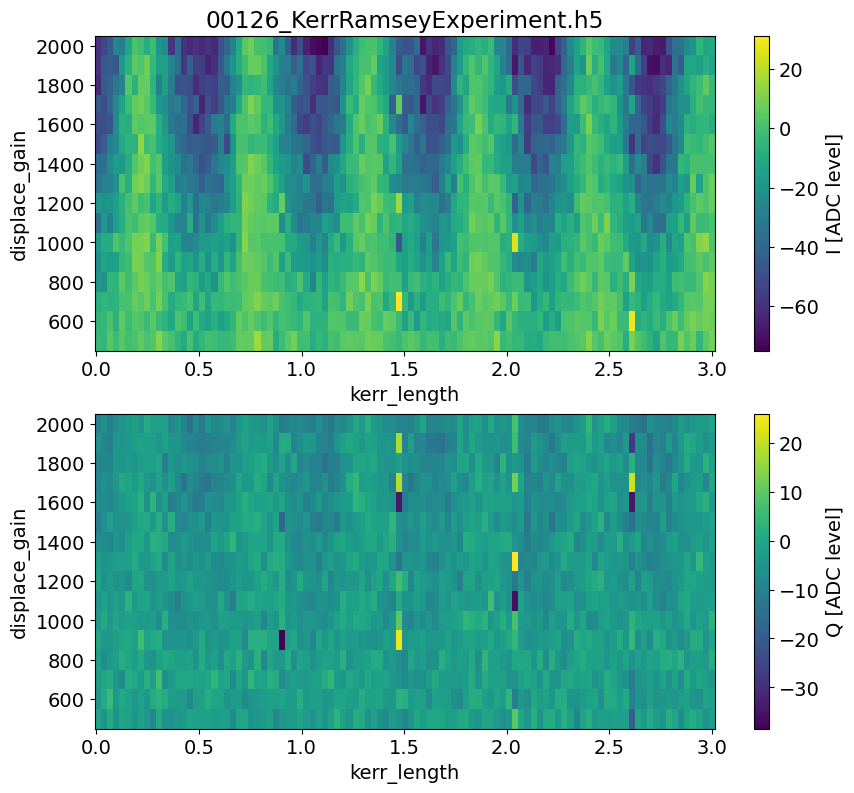

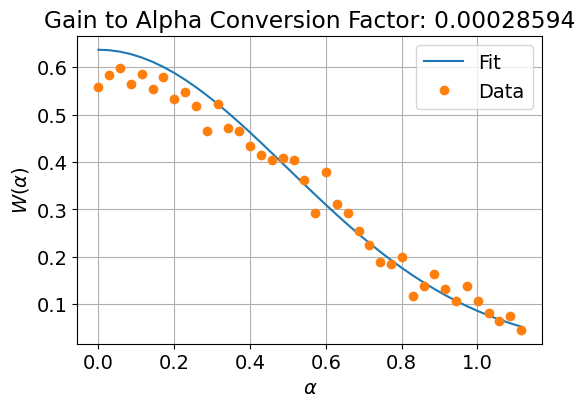

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-05_00-34-17_Gain_to_Alpha_Conversion_Factor_0.00028594.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-05.md
alpha = 1 requires gain of : 3497.23103804
Gain to alpha: 0.0002859405023926809


  0%|          | 0/16 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00127_KerrRamseyExperiment.h5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00080_ParityFreqExperiment.h5
Pulse correction is applied
4993.86402893229
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

4993.86402893229
parity pulse: [[3569.7124052990084, 3569.7124052990084, 3569.7124052990084], [1714, 0, 1714], [0.0, 1.6251210080098948, 0.0], [0, 0, 0], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.035, 0.0, 0.035]]
Updating gain register 100


  0%|          | 0/8000 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00007_ParityGainExperiment.h5
(200, 40)
(200, 40)
Gain to Alpha Conversion Factor: 0.00030102387737308194


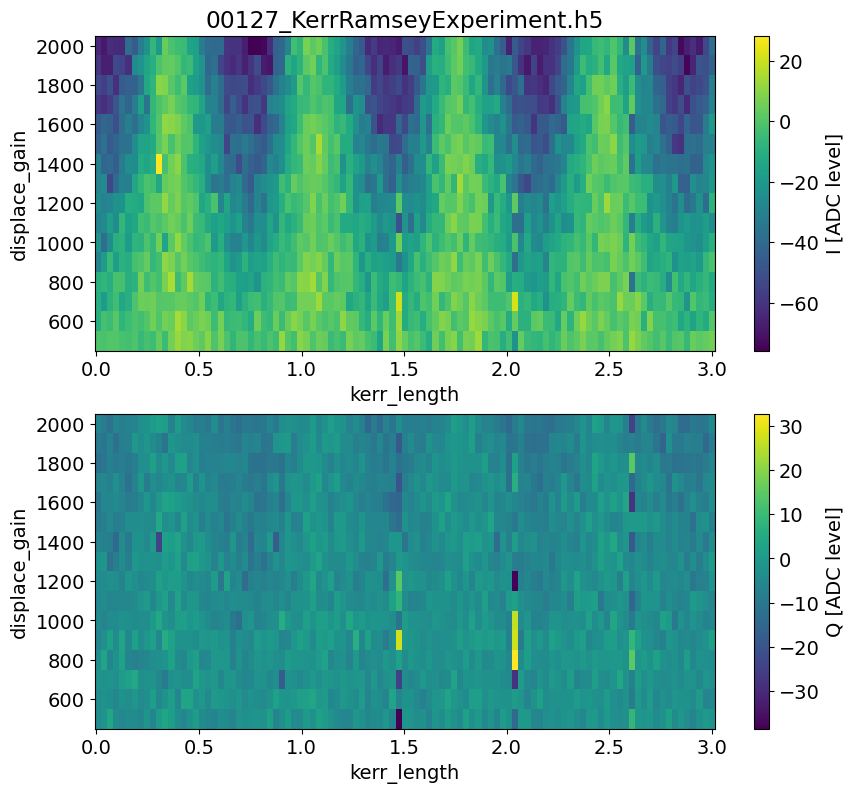

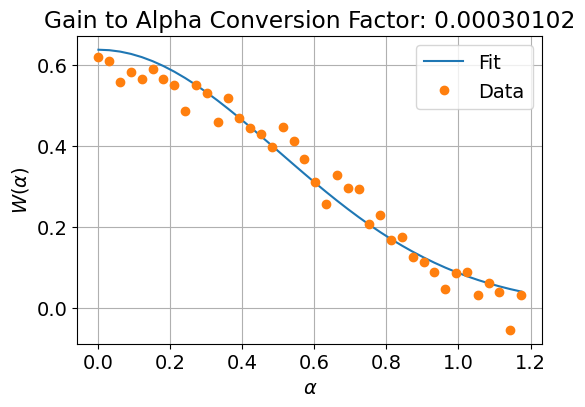

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-05_00-48-49_Gain_to_Alpha_Conversion_Factor_0.00030102.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-05.md
alpha = 1 requires gain of : 3321.99561286
Gain to alpha: 0.00030102387737308194


  0%|          | 0/16 [00:00<?, ?it/s]

Saving D:\experiments\251031_qsim\data\00128_KerrRamseyExperiment.h5


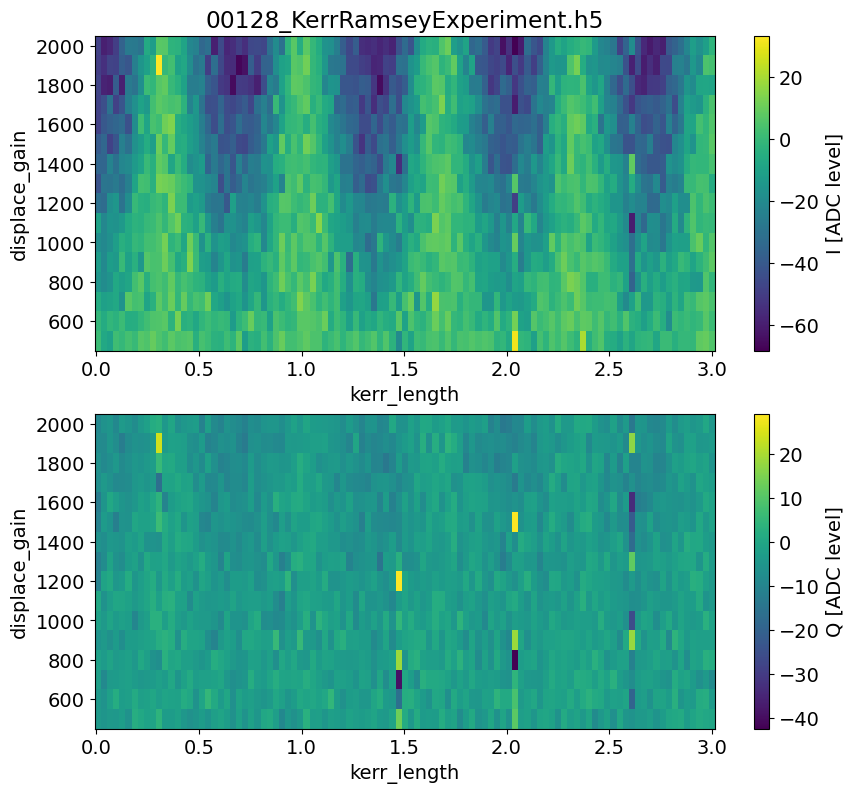

In [30]:
flux_currents = np.linspace(0, 0.15e-3, 6)
for flux_current in flux_currents:
    # set current
    dcflux.ramp_current(flux_current, sweeprate=1e-4)
    parity_freq_exp = do_parity_freq_experiment()

    # find manipulate f_ge
    spec = Spectroscopy(parity_freq_exp.data, config=parity_freq_exp.cfg)
    spec.analyze()
    config_thisrun.device.manipulate.f_ge[0] = spec.data['fit_avgi'][2]

    # calibrate parity to gain
    parity_gain_expt = do_parity_gain_experiment(
        config_thisrun=config_thisrun,
        expt_path=expt_path,
        config_path=config_file,
        pulse_correction=True,
        reps=200,
    )
    parity_gain_expt.analyze()
    gain_to_alpha = parity_gain_expt.data['gain_to_alpha']
    print(f'Gain to alpha: {gain_to_alpha}')
    config_thisrun.device.manipulate.gain_to_alpha[0] = gain_to_alpha
    
    # do cavity ramsey
    kerr_ramsey = do_kerr_ramsey(
        config_thisrun=config_thisrun,
        expt_path=expt_path,
        config_path=config_file,
        ramsey_freq=1.5,
        kerr_gain=0,
        # step = 0.04, 
        # expts = 150, 
        reps = 100,
        prep_e_first=False,
        # active_reset=True,
        # man_reset=True,
        # relax_delay=300,
    )